In [1]:
import javalang
import json
import re
import time
import random
import nltk
nltk.download('punkt')
import numpy as np
import pickle
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import math
import seaborn as sns

MODE = "normal"  #normal or simple
BATCH_SIZE = 32
EMBEDDING_DIM = 256
UNITS = 256

[nltk_data] Downloading package punkt to /home/yurong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Function declaration

In [2]:
'''
Function：
    Input the code token list, comment string，and return whether it's invalid
The rule of valid method:
    1. code token size <= 100
    2. One-sentence-comment（I hope model generate only one sentence.
       If training data consist multi-sentence comment, the effect will be bad and the first sentence only can not
       properly describe the functionality of the method）

PS: I regard "tester", "setter", "getter" and "constructor" as valid method
'''
def is_invalid_method(token_len, nl):   
    if token_len > 100:
        return True
    if len(nl.split('.')) != 1 or len(nltk.word_tokenize(nl)) > 30:
        return True
    else :
        return False
    
    
'''
Function: 
    Input the root of AST and the deep of the tree, 
    it will filter the null value and return the list of SBT (structural-based travesal) and print the tree structure
'''
def parse_tree(root, deep):

    seq = []
    seq.extend(['(', str(root).split('(')[0]])
    #print('\t'*(deep)+str(root).split('(')[0])    # show node name
    for attr in root.attrs:
        if eval('root.%s' % attr) in [None, [], "", set(), False]:    # filter the null attr
            continue
        elif isinstance(eval('root.%s' % attr), list):
            x = eval('root.%s' % attr)
            if not all(elem in x for elem in [None, [], "", set(), False]):    # if not all elements in list are null
                seq.extend(['(',attr])
                #print('\t'*(deep+1)+attr)
                #deep += 1
                for i in eval('root.%s' % attr):    # recursive the list
                    if i is None or isinstance(i, str):    # perhaps it has None value in the list
                        continue
                    #deep += 1
                    seq.extend(parse_tree(i, deep))
                    
                    #deep -= 1
                #deep -= 1
                seq.extend([')',attr])
        elif 'tree' in str(type(eval('root.%s' % attr))):    #if the attr is one kind of Node, recursive the Node
            seq.extend(['(',attr])
            #print('\t'*(deep+1)+attr)
            #deep += 2
            seq.extend(parse_tree(eval('root.%s' % attr), deep))
            #deep -= 2
            seq.extend([')',attr])
        else:
            seq.extend(['(','<'+str(attr)+'>_'+str(eval('root.%s' % attr)),')','<'+str(attr)+'>_'+str(eval('root.%s' % attr))])
            #exec("print('\t'*(deep+1)+attr+': '+str(root.%s))" % attr)    #it must be normal attribute
    seq.extend([')', str(root).split('(')[0]])
    return seq




'''
Function:
    1. "camelCase" -> ["camel", "Case"]
    2. "under_score" -> ["under", "_", "score"]
    3. "normal" -> ["normal"]
'''
def split_identifier(id_token):
    if  "_" in id_token:
        return id_token.split("_")
    elif id_token != id_token.lower() and id_token != id_token.upper():
        matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', id_token)
        return [m.group(0) for m in matches]
    else:
        return [id_token]

    
    
'''
Function:
    1. input the list of train, test, valid dataset
    2. filter the dataset, split it to train, test, valid set and save as the smaller dataset.
    3. return the amount of the data from smaller datasets.
Example:
    filter_dataset(['./data/train.json', './data/test.json', './data/valid.json'], './data')
Note:
    The filter method is different from the method in DeepCom, because I have no idea how DeepCom did.
    It doesn't make sense that DeepCom could filter so many data via the method mentioned in its paper.
'''
def filter_dataset(path_list, save_path):
    
    inputs = []
    for path in path_list:
        input_file = open(path)
        inputs.extend(input_file.readlines())
        input_file.close()
    outputs = []
    output_train_file = open(save_path+'/filter_train.json', "w")
    output_test_file = open(save_path+'/filter_test.json', "w")
    output_valid_file = open(save_path+'/filter_valid.json', "w")
    
    print('Original total: '+str(len(inputs)))
    for pair in inputs:
        pair = json.loads(pair)
        tokens_parse = javalang.tokenizer.tokenize(pair['code'])
        if is_invalid_method(len(list(tokens_parse)), pair['nl']):
            continue
        outputs.append(json.dumps(pair))

    random.shuffle(outputs)
    print('Final total: '+str(len(outputs)))
    print('Data shuffle complete')
    train_index = int(len(outputs)*0.8)
    test_index = int(len(outputs)*0.9)
    train_output = outputs[:train_index]
    test_output = outputs[train_index+1:test_index]
    valid_output = outputs[test_index+1:]
    
    for row in train_output:
        output_train_file.write(row+'\n')
    output_train_file.close()
    print('filter train data finish writing')
    for row in test_output:
        output_test_file.write(row+'\n')
    output_test_file.close()
    print('filter test data finish writing')
    for row in valid_output:
        output_valid_file.write(row+'\n')
    print('filter valid data finish writing')
    output_valid_file.close()

    return len(train_output), len(test_output), len(valid_output)


'''
Parameters:
    path: the path of the data you want to read
    code_voc: code vocabulary, the data type is list
    comment_voc: comment vocabulary, the data type is list
    mode: "simple" or "normal"
Return values:
    code_tokens, comment_tokens: 2-dimension list, store the code and comment into list, snippet by snippet
    code_voc, comment_voc: the all vocabularies in the file of the path, data type is list
Note:
    It hasn't used SBT in DeepCom.
TODO:
    Change the rare words in comments into other common words via pre-trained embedding
'''
def readdata(path, code_voc, comment_voc, mode):
    input_file = open(path)
    inputs = input_file.readlines()

    code_tokens = []          # code_tokens = ['<START>', '<Modifier>', 'public', '<Identifier>',....]
    comment_tokens = []       # comment_tokens = []

    start = time.time()
    for index, pair in enumerate(inputs):
        if index%5000 == 0 and index != 0:
            print(index)
        pair = json.loads(pair)
        # =============== extract the code part of the snippet =========================
        
        tokens_parse = javalang.tokenizer.tokenize(pair['code'])
        tokens = []
        
        if mode == "normal":
            for token in tokens_parse:    # iterate the tokens of the sentence
                token = str(token).split(' ')
                splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and under_score
                temp = ['<'+token[0]+'>']    # token[0] is token type, token[1] is token value
                temp.extend(splitted_id)
                tokens.extend(temp)
                for x in tokens:
                    if x not in code_voc:
                        code_voc.append(x)
        elif mode == "simple":
            for token in tokens_parse:    # iterate the tokens of the sentence
                token = str(token).split(' ')
                splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and under_score
                tokens.extend(splitted_id)
                for x in tokens:
                    if x not in code_voc:
                        code_voc.append(x)
            
        tokens.insert(0, '<START>')
        tokens.append('<END>')
        code_tokens.append(tokens)
        
        #=============== extract comment part of the snippet ==========================
        tokens = nltk.word_tokenize(pair['nl'])
        tokens.append('<END>')
        comment_tokens.append(tokens)
        for x in tokens:
            if x not in comment_voc:
                comment_voc.append(x)

    print('readdata:')
    print('\tdata amount: '+str(len(code_tokens)))
    print('\trun time: '+str(time.time()-start))

    input_file.close()
    return code_tokens, comment_tokens, code_voc, comment_voc


'''
Usage:
    Transform the token to the index in vocabulary
    ['<START>', '<Modifier>', 'public', ..., '<Separator>', ';', '<Separator>', '}', '<END>']
    => [0, 7, 8, ..., 14, 29, 14, 30, 1]
Parameter data type: 
    2-dimension list
Return data type:
    2-dimension list
'''
def token2index(lst, voc):
    for index, seq in enumerate(lst):
        seq_index = []
        for token in seq:
            seq_index.append(voc.index(token))
        lst[index] = seq_index
    return lst


'''
Parameters:
    lst: the list of sequences to be padded
    pad_data: the value you want to pad
Return type:
    numpy array
'''
def pad_sequences(lst, pad_data):
    maxlen = max(len(x) for x in lst)
    for index, seq in enumerate(lst):
        lst[index].extend([pad_data] * (maxlen-len(seq)))
    return np.array(lst)

'''
Parameters:
    x: the list of data
    batch_sz: batch size
Return shape:
    [None, batch_sz, None]
Example:
    a = [1,2,3,4,5,6,7,8,9,10]
    a = getBatch(x=a, batch_sz=3)
    a
    ---output---
    [[1,2,3], [4,5,6], [7,8,9]]
'''
def getBatch(x, batch_sz):
    dataset = []
    while(len(x)>=batch_sz):
        dataset.append(x[:batch_sz])
        x = x[batch_sz:]
    if type(x) == np.ndarray:
        return np.array(dataset)
    elif type(x) == list:
        return dataset
    
def ngram(words, n):
    return list(zip(*(words[i:] for i in range(n))))


#  bleu4 (n=4)
def bleu(true, pred, n):
    true = nltk.word_tokenize(true)
    pred = nltk.word_tokenize(pred)
    c = len(pred)
    r = len(true)
    bp = 1. if c > r else np.exp(1 - r / (c + 1e-10))
    score = 0
    
    for i in range(1, n+1):
        true_ngram = set(ngram(true, i))
        pred_ngram = ngram(pred, i)
        if len(true_ngram)==0 or len(true_ngram)==0:
            break
        length = float(len(pred_ngram)) + 1e-10
        count = sum([1. if t in true_ngram else 0. for t in pred_ngram])
        score += math.log(1e-10 + (count / length))
    score = math.exp(score / n)  #n就是公式的Wn
    bleu = bp * score
    return bleu


def evaluate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ, mode):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    inputs = code_tokenize(code, mode)
    
    inputs += ['<PAD>'] * (max_length_inp - len(inputs))
    for index, token in enumerate(inputs):
        if token not in code_voc:
            inputs[index] = code_voc.index('<UNK>')
        else:
            inputs[index] = code_voc.index(token)
    inputs = np.array(inputs)
    inputs = tf.expand_dims(inputs, 0)
    
    result = ''
    
    hidden_h, hidden_c = tf.zeros((1, UNITS)), tf.zeros((1, UNITS))
    hidden = [hidden_h, hidden_c]
    enc_output, enc_hidden_h, enc_hidden_c = encoder(inputs, hidden)
    dec_hidden = [enc_hidden_h, enc_hidden_c]
    
    dec_input = tf.expand_dims([comment_voc.index('<START>')], 1)       
    
    for t in range(max_length_targ):
        predictions, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, dec_hidden, enc_output)
        dec_hidden = [dec_hidden_h, dec_hidden_c]
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        if comment_voc[predicted_id] == '<END>':
            return result, code, attention_plot
        
        result += comment_voc[predicted_id] + ' '
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, code, attention_plot


# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    sns.set()
    fig, ax = plt.subplots(figsize=(20,10)) 
    sns.heatmap(attention, xticklabels=sentence, yticklabels=predicted_sentence, ax=ax)
    

def translate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ, mode):
    result, code, attention_plot = evaluate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ, mode)
    #attention_plot = attention_plot[:len(result.split(' ')), :len(code_tokenize(code, mode))]
    #attention_plot = distribution(attention_plot)
    #plot_attention(attention_plot, code_tokenize(code, mode), result.split(' ')+['<END>'])
    return result

def code_tokenize(code, mode):
    tokens_parse = javalang.tokenizer.tokenize(code)
    inputs = []
    if mode =="simple":
        for token in tokens_parse:    # iterate the tokens of the sentence
            token = str(token).split(' ')
            splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and under_score
            inputs.extend(splitted_id)
    elif mode == "normal":
        for token in tokens_parse:    # iterate the tokens of the sentence
            token = str(token).split(' ')
            splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and under_score
            temp = ['<'+token[0]+'>']    # token[0] is token type, token[1] is token value
            temp.extend(splitted_id)
            inputs.extend(temp)

    inputs.insert(0, '<START>')
    inputs.append('<END>')
    
    return inputs


'''
用途：把一個二維的array做機率正規化
例如：[[3,4,5],[1,2,3]] -> [[0.25, 0.33, 0.416], [0.167, 0.333, 0.5]]
'''
def distribution(arr):
    new_arr = []
    for i in arr:
        tmp = []
        total = sum(i)
        for x in i:
            tmp.append(x/total)
        new_arr.append(tmp)
    return np.array(new_arr)





## Prune the original big dataset into simpler and better dataset
* #### Size of training set, testing set and valid set ->  (81932, 10241, 10241)
* #### If you already have "filter_train.json", "filter_test.json" and "filter_valid.json", then you can skip this code cell.

In [7]:
filter_dataset(['./data/train.json', './data/test.json', './data/valid.json'], './filter_dataset')


Original total: 588108
Final total: 101220
Data shuffle complete
filter train data finish writing
filter test data finish writing
filter valid data finish writing


(80976, 10121, 10121)

## Reading training data (it costs about 40 mins)
* #### If you already have 'train_data.pkl', you can skip this code cell below and directly read 'train_data.pkl'

In [4]:
code_voc = ['<PAD>','<START>','<END>','<UNK>']
comment_voc = ['<PAD>','<START>','<END>','<UNK>']
code_train, comment_train, code_voc, comment_voc = readdata('./filter_dataset/filter_train.json', code_voc, comment_voc, mode="normal")

code_train = token2index(code_train, code_voc)
comment_train = token2index(comment_train, comment_voc)
code_train = pad_sequences(code_train, code_voc.index('<PAD>'))
comment_train = pad_sequences(comment_train, comment_voc.index('<PAD>'))
print('size of code vocabulary: ', len(code_voc))
print('size of comment vocabulary: ', len(comment_voc))

# Saving the training data:
with open('train_data.pkl', 'wb') as f:
    pickle.dump([code_train, comment_train, code_voc, comment_voc], f)

5000
10000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
readdata:
	data amount: 80976
	run time: 2356.8662514686584
size of code vocabulary:  42152
size of comment vocabulary:  29404


## Read the pickle file of dataset

In [3]:
# Getting back the training data:
if MODE=="normal":
    with open('train_data.pkl', 'rb') as f:
        code_train, comment_train, code_voc, comment_voc = pickle.load(f)
elif MODE=="simple":
    with open('train_simple_data.pkl', 'rb') as f:
        code_train, comment_train, code_voc, comment_voc = pickle.load(f)
    
print('size of code vocabulary: ', len(code_voc))
print('size of comment vocabulary: ', len(comment_voc))

size of code vocabulary:  42152
size of comment vocabulary:  29404


## Just test the functionality of transforming source code to SBT

In [ ]:
input_file = open('./data/test.json')
inputs = input_file.readlines()
pair = json.loads(inputs[0])
tree = javalang.parse.parse('class aa {'+pair['code']+'}')
print(pair['code'], end='\n')

_, node = list(tree)[2]    # 前兩個用來篩掉class aa{ }的部分
seq = parse_tree(node, 0)
for i in seq:
    print(i,end='')


## Define the deep learing models

In [4]:
def lstm(units):
    return tf.keras.layers.LSTM(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = lstm(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x, initial_state = hidden)        
        return output, state_h, state_c
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = lstm(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        hidden_with_time_axis = tf.expand_dims(hidden[1], 1)
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state_h, state_c = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        
        return x, state_h, state_c, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units)), tf.zeros((self.batch_sz, self.dec_units))

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

## Set some parameters and build the models

In [6]:
BUFFER_SIZE = len(code_train)
N_BATCH = BUFFER_SIZE//BATCH_SIZE

vocab_inp_size = len(code_voc)
vocab_tar_size = len(comment_voc)

max_length_inp = max(len(t) for t in code_train)
max_length_targ = max(len(t) for t in comment_train)

encoder = Encoder(vocab_inp_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)

optimizer = tf.optimizers.Adam(learning_rate=1e-3)  #tensorflow 2.0


# ==== set the checkpoint =======
checkpoint_dir = './training_checkpoints/adam-normal-256-60epochs'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
lossArray = np.array([])

## Start training

Epoch 1 Batch 0 Loss 2.7382
Epoch 1 Batch 500 Loss 1.7608
Epoch 1 Batch 1000 Loss 1.8481
Epoch 1 Batch 1500 Loss 1.3759
Epoch 1 Batch 2000 Loss 1.3539
Epoch 1 Batch 2500 Loss 1.5885
Epoch 1 Loss 1.6053
Time taken for 1 epoch 1629.994776725769 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Add a new instance of the given message 
bleu4:  1.0000000000124996e-10

Epoch 2 Batch 0 Loss 1.5518
Epoch 2 Batch 500 Loss 1.4758
Epoch 2 Batch 1000 Loss 1.3553
Epoch 2 Batch 1500 Loss 1.1750
Epoch 2 Batch 2000 Loss 1.3941
Epoch 2 Batch 2500 Loss 1.0531
Epoch 2 Loss 1.2740
Time taken for 1 epoch 1638.7080700397491 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Send a new instance of the given position 

Epoch 17 Batch 0 Loss 0.3175
Epoch 17 Batch 500 Loss 0.1915
Epoch 17 Batch 1000 Loss 0.1939
Epoch 17 Batch 1500 Loss 0.3234
Epoch 17 Batch 2000 Loss 0.2738
Epoch 17 Batch 2500 Loss 0.4411
Epoch 17 Loss 0.3018
Time taken for 1 epoch 1647.479487657547 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  This method creates a new state 
bleu4:  7.165313105897119e-11

Epoch 18 Batch 0 Loss 0.3145
Epoch 18 Batch 500 Loss 0.2688
Epoch 18 Batch 1000 Loss 0.2517
Epoch 18 Batch 1500 Loss 0.3028
Epoch 18 Batch 2000 Loss 0.3181
Epoch 18 Batch 2500 Loss 0.2886
Epoch 18 Loss 0.2865
Time taken for 1 epoch 1648.5070021152496 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Sends the interface for the given str

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 22 Batch 0 Loss 0.1353
Epoch 22 Batch 500 Loss 0.1777
Epoch 22 Batch 1000 Loss 0.2115
Epoch 22 Batch 1500 Loss 0.3734
Epoch 22 Batch 2000 Loss 0.2001
Epoch 22 Batch 2500 Loss 0.1452
Epoch 22 Loss 0.2159
Time taken for 1 epoch 1652.5720546245575 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  This method adds an interface for a new state 
bleu4:  1.8257418587562708e-08



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 23 Batch 0 Loss 0.2116
Epoch 23 Batch 500 Loss 0.2539
Epoch 23 Batch 1000 Loss 0.2183
Epoch 23 Batch 1500 Loss 0.2151
Epoch 23 Batch 2000 Loss 0.1903
Epoch 23 Batch 2500 Loss 0.2351
Epoch 23 Loss 0.2009
Time taken for 1 epoch 1657.6413345336914 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Initialize the interface to allow the interface for a custom request 
bleu4:  1.7364082029932466e-08



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 24 Batch 0 Loss 0.2618
Epoch 24 Batch 500 Loss 0.1002
Epoch 24 Batch 1000 Loss 0.2037
Epoch 24 Batch 1500 Loss 0.1501
Epoch 24 Batch 2000 Loss 0.1936
Epoch 24 Batch 2500 Loss 0.1255
Epoch 24 Loss 0.1891
Time taken for 1 epoch 1662.0105893611908 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  This method is used to allow the interface for a CacheServer 
bleu4:  9.999999999999996e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 25 Batch 0 Loss 0.1342
Epoch 25 Batch 500 Loss 0.1569
Epoch 25 Batch 1000 Loss 0.2165
Epoch 25 Batch 1500 Loss 0.2408
Epoch 25 Batch 2000 Loss 0.1886
Epoch 25 Batch 2500 Loss 0.1975
Epoch 25 Loss 0.1775
Time taken for 1 epoch 1647.1393835544586 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  This method is used to allow the interface Save for the specified properties 
bleu4:  9.999999999999996e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 26 Batch 0 Loss 0.0644
Epoch 26 Batch 500 Loss 0.2263
Epoch 26 Batch 1000 Loss 0.2315
Epoch 26 Batch 1500 Loss 0.1601
Epoch 26 Batch 2000 Loss 0.1533
Epoch 26 Batch 2500 Loss 0.2123
Epoch 26 Loss 0.1665
Time taken for 1 epoch 1656.243831396103 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Sends a custom map with a specific case 
bleu4:  2.2360679777443597e-08



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 27 Batch 0 Loss 0.0528
Epoch 27 Batch 500 Loss 0.1771
Epoch 27 Batch 1000 Loss 0.1680
Epoch 27 Batch 1500 Loss 0.1778
Epoch 27 Batch 2000 Loss 0.1137
Epoch 27 Batch 2500 Loss 0.1952
Epoch 27 Loss 0.1560
Time taken for 1 epoch 1641.620168685913 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  This method sets the interface for the server 
bleu4:  1.0000000000124996e-10



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 28 Batch 0 Loss 0.1828
Epoch 28 Batch 500 Loss 0.1126
Epoch 28 Batch 1000 Loss 0.1334
Epoch 28 Batch 1500 Loss 0.1524
Epoch 28 Batch 2000 Loss 0.1899
Epoch 28 Batch 2500 Loss 0.1569
Epoch 28 Loss 0.1480
Time taken for 1 epoch 1655.3517458438873 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  This method is used to allow the BodyContent from the server 
bleu4:  9.999999999999996e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 29 Batch 0 Loss 0.1480
Epoch 29 Batch 500 Loss 0.0648
Epoch 29 Batch 1000 Loss 0.1622
Epoch 29 Batch 1500 Loss 0.0909
Epoch 29 Batch 2000 Loss 0.1423
Epoch 29 Batch 2500 Loss 0.1492
Epoch 29 Loss 0.1395
Time taken for 1 epoch 1643.7750868797302 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  This method is used to set the code to the message and the message 
bleu4:  9.999999999999996e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 30 Batch 0 Loss 0.1150
Epoch 30 Batch 500 Loss 0.1040
Epoch 30 Batch 1000 Loss 0.0843
Epoch 30 Batch 1500 Loss 0.1594
Epoch 30 Batch 2000 Loss 0.1685
Epoch 30 Batch 2500 Loss 0.1513
Epoch 30 Loss 0.1331
Time taken for 1 epoch 1651.3570256233215 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Sends the interface for the given register 
bleu4:  1.685324061307668e-08



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 31 Batch 0 Loss 0.1299
Epoch 31 Batch 500 Loss 0.0964
Epoch 31 Batch 1000 Loss 0.1344
Epoch 31 Batch 1500 Loss 0.0933
Epoch 31 Batch 2000 Loss 0.1490
Epoch 31 Batch 2500 Loss 0.2030
Epoch 31 Loss 0.1259
Time taken for 1 epoch 1650.0764274597168 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  This method allows to setup the socket and the request headers for the server 
bleu4:  9.999999999999996e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 32 Batch 0 Loss 0.0559
Epoch 32 Batch 500 Loss 0.1176
Epoch 32 Batch 1000 Loss 0.0751
Epoch 32 Batch 1500 Loss 0.1283
Epoch 32 Batch 2000 Loss 0.1207
Epoch 32 Batch 2500 Loss 0.0570
Epoch 32 Loss 0.1181
Time taken for 1 epoch 1643.393743276596 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Predictedd translation:  This method is used to allow subclasses to allow subclasses that the socket and initializes the message and initializes the message and initializes the message and initializes the message and initializes 
bleu4:  9.999999999999996e-11

Epoch 33 Batch 0 Loss 0.1122
Epoch 33 Batch 500 Loss 0.0747
Epoch 33 Batch 1000 Loss 0.1803
Epoch 33 Batch 1500 Loss 0.1312
Epoch 33 Batch 2000 Loss 0.1914
Epoch 33 Batch 2500 Loss 0.1369
Epoch 33 Loss 0.1132
Time taken for 1 epoch 1637.0100848674774 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Predictedd translation:  This method allows to setup a single datasource to a message to the external DCC packet 
bleu4:  1.5811388307141717e-08

Epoch 34 Batch 0 Loss 0.1514
Epoch 34 Batch 500 Loss 0.1138
Epoch 34 Batch 1000 Loss 0.0832
Epoch 34 Batch 1500 Loss 0.0993
Epoch 34 Batch 2000 Loss 0.1183
Epoch 34 Batch 2500 Loss 0.0763
Epoch 34 Loss 0.1076
Time taken for 1 epoch 1652.2914798259735 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Predictedd translation:  Initiate a payment statement to the error message to the error message to the error message to the error message to the error message to the error message to the error 
bleu4:  9.999999999999996e-11

Epoch 35 Batch 0 Loss 0.1282
Epoch 35 Batch 500 Loss 0.0630
Epoch 35 Batch 1000 Loss 0.0838
Epoch 35 Batch 1500 Loss 0.1405
Epoch 35 Batch 2000 Loss 0.1476
Epoch 35 Batch 2500 Loss 0.1745
Epoch 35 Loss 0.1048
Time taken for 1 epoch 1646.3394055366516 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Initiate a single block to the message has no code 
bleu4:  9.999999999999996e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 36 Batch 0 Loss 0.0874
Epoch 36 Batch 500 Loss 0.0493
Epoch 36 Batch 1000 Loss 0.1110
Epoch 36 Batch 1500 Loss 0.0424
Epoch 36 Batch 2000 Loss 0.1005
Epoch 36 Batch 2500 Loss 0.1397
Epoch 36 Loss 0.0971
Time taken for 1 epoch 1644.4492201805115 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Initiate a player to the external tool 
bleu4:  8.668778997643345e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 37 Batch 0 Loss 0.1292
Epoch 37 Batch 500 Loss 0.0506
Epoch 37 Batch 1000 Loss 0.1134
Epoch 37 Batch 1500 Loss 0.0673
Epoch 37 Batch 2000 Loss 0.0611
Epoch 37 Batch 2500 Loss 0.0805
Epoch 37 Loss 0.0923
Time taken for 1 epoch 1645.8294758796692 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Predictedd translation:  This method is used to set the security manager and not this , no code , no reason 
bleu4:  9.999999999999996e-11

Epoch 38 Batch 0 Loss 0.0244
Epoch 38 Batch 500 Loss 0.0723
Epoch 38 Batch 1000 Loss 0.0771
Epoch 38 Batch 1500 Loss 0.1126
Epoch 38 Batch 2000 Loss 0.0881
Epoch 38 Batch 2500 Loss 0.1056
Epoch 38 Loss 0.0899
Time taken for 1 epoch 1639.0507245063782 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Predictedd translation:  Initializes this event to the message to the message to the message to the message to the message to the message to the message to the message to the message to 
bleu4:  9.999999999999996e-11

Epoch 39 Batch 0 Loss 0.0740
Epoch 39 Batch 500 Loss 0.1439
Epoch 39 Batch 1000 Loss 0.1071
Epoch 39 Batch 1500 Loss 0.0849
Epoch 39 Batch 2000 Loss 0.1111
Epoch 39 Batch 2500 Loss 0.0841
Epoch 39 Loss 0.0855
Time taken for 1 epoch 1627.5987799167633 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Predictedd translation:  This method creates a configuration for the provided HTTP method to allow the player to the external tool 
bleu4:  9.999999999999996e-11

Epoch 40 Batch 0 Loss 0.1120
Epoch 40 Batch 500 Loss 0.0499
Epoch 40 Batch 1000 Loss 0.0920
Epoch 40 Batch 1500 Loss 0.1612
Epoch 40 Batch 2000 Loss 0.0949
Epoch 40 Batch 2500 Loss 0.1538
Epoch 40 Loss 0.0830
Time taken for 1 epoch 1637.6547164916992 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Predictedd translation:  Instantiates the update packet to the message was the new request , and the message 
bleu4:  1.9108855847638387e-08

Epoch 41 Batch 0 Loss 0.0292
Epoch 41 Batch 500 Loss 0.0623
Epoch 41 Batch 1000 Loss 0.0845
Epoch 41 Batch 1500 Loss 0.0427
Epoch 41 Batch 2000 Loss 0.0793
Epoch 41 Batch 2500 Loss 0.1265
Epoch 41 Loss 0.0797
Time taken for 1 epoch 1640.0848784446716 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Initiate the interface to the external tool 
bleu4:  8.668778997643345e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 42 Batch 0 Loss 0.0495
Epoch 42 Batch 500 Loss 0.0655
Epoch 42 Batch 1000 Loss 0.0881
Epoch 42 Batch 1500 Loss 0.0797
Epoch 42 Batch 2000 Loss 0.1085
Epoch 42 Batch 2500 Loss 0.0778
Epoch 42 Loss 0.0753
Time taken for 1 epoch 1650.2531232833862 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Initializes the interface for the provided report methods 
bleu4:  1.0000000000124996e-10



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 43 Batch 0 Loss 0.0413
Epoch 43 Batch 500 Loss 0.0638
Epoch 43 Batch 1000 Loss 0.0439
Epoch 43 Batch 1500 Loss 0.0533
Epoch 43 Batch 2000 Loss 0.0594
Epoch 43 Batch 2500 Loss 0.1065
Epoch 43 Loss 0.0726
Time taken for 1 epoch 1647.366786956787 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Set this to send the player to the external leaf request , it 
bleu4:  9.999999999999996e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 44 Batch 0 Loss 0.0334
Epoch 44 Batch 500 Loss 0.0811
Epoch 44 Batch 1000 Loss 0.0718
Epoch 44 Batch 1500 Loss 0.0480
Epoch 44 Batch 2000 Loss 0.0570
Epoch 44 Batch 2500 Loss 0.0956
Epoch 44 Loss 0.0738
Time taken for 1 epoch 1639.6825313568115 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Creates a custom request to the external tool 
bleu4:  1.880301546936881e-08



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 45 Batch 0 Loss 0.0659
Epoch 45 Batch 500 Loss 0.0319
Epoch 45 Batch 1000 Loss 0.0832
Epoch 45 Batch 1500 Loss 0.0842
Epoch 45 Batch 2000 Loss 0.0444
Epoch 45 Batch 2500 Loss 0.1257
Epoch 45 Loss 0.0677
Time taken for 1 epoch 1643.9906153678894 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Predictedd translation:  Initiate a protocol message to the message to the message to the message to the message to the message to the message to the message to the message to the message 
bleu4:  9.999999999999996e-11

Epoch 46 Batch 0 Loss 0.0425
Epoch 46 Batch 500 Loss 0.0609
Epoch 46 Batch 1000 Loss 0.0469
Epoch 46 Batch 2000 Loss 0.0814
Epoch 46 Batch 2500 Loss 0.0574
Epoch 46 Loss 0.0595
Time taken for 1 epoch 1645.267605304718 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Initializes the player to the message 
bleu4:  7.165313105897119e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 47 Batch 0 Loss 0.0558
Epoch 47 Batch 500 Loss 0.0634
Epoch 47 Batch 1000 Loss 0.1234
Epoch 47 Batch 1500 Loss 0.0829
Epoch 47 Batch 2000 Loss 0.0793
Epoch 47 Batch 2500 Loss 0.0811
Epoch 47 Loss 0.0608
Time taken for 1 epoch 1644.7454297542572 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Initializes the issue with a custom request organizer message and sets a custom request 
bleu4:  1.9441308421507157e-08



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 48 Batch 0 Loss 0.0507
Epoch 48 Batch 500 Loss 0.0958
Epoch 48 Batch 1000 Loss 0.0660
Epoch 48 Batch 1500 Loss 0.0734
Epoch 48 Batch 2000 Loss 0.0404
Epoch 48 Batch 2500 Loss 0.0692
Epoch 48 Loss 0.0701
Time taken for 1 epoch 1648.5411584377289 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Set this handler to the message 
bleu4:  7.165313105897119e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 49 Batch 0 Loss 0.0326
Epoch 49 Batch 500 Loss 0.1146
Epoch 49 Batch 1000 Loss 0.0862
Epoch 49 Batch 1500 Loss 0.1038
Epoch 49 Batch 2000 Loss 0.0520
Epoch 49 Batch 2500 Loss 0.0970
Epoch 49 Loss 0.0580
Time taken for 1 epoch 1645.025297164917 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Sends the response to the flow 
bleu4:  1.4477626228439056e-08



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 50 Batch 0 Loss 0.0435
Epoch 50 Batch 500 Loss 0.0736
Epoch 50 Batch 1000 Loss 0.1030
Epoch 50 Batch 1500 Loss 0.0639
Epoch 50 Batch 2000 Loss 0.0943
Epoch 50 Batch 2500 Loss 0.0580
Epoch 50 Loss 0.0753
Time taken for 1 epoch 1643.1772561073303 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Adds an update to be resolved 
bleu4:  1.7216896117918452e-08



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 51 Batch 0 Loss 0.0702
Epoch 51 Batch 500 Loss 0.0234
Epoch 51 Batch 1000 Loss 0.0725
Epoch 51 Batch 1500 Loss 0.0882
Epoch 51 Batch 2000 Loss 0.1139
Epoch 51 Batch 2500 Loss 0.0649
Epoch 51 Loss 0.0643
Time taken for 1 epoch 1646.0395362377167 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Sends the protocol message to the parameters 
bleu4:  1.685324061307668e-08



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 52 Batch 0 Loss 0.0696
Epoch 52 Batch 500 Loss 0.0474
Epoch 52 Batch 1000 Loss 0.0757
Epoch 52 Batch 1500 Loss 0.0332
Epoch 52 Batch 2000 Loss 0.0604
Epoch 52 Loss 0.0538
Time taken for 1 epoch 1644.016259431839 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Predictedd translation:  Sends the parse to do n't do n't do n't do n't do n't do n't do n't do n't do n't do n't do n't do n't do n't do 
bleu4:  1.340169027790425e-08

Epoch 53 Batch 0 Loss 0.0452
Epoch 53 Batch 500 Loss 0.0177
Epoch 53 Batch 1000 Loss 0.0389
Epoch 53 Batch 1500 Loss 0.0345
Epoch 53 Batch 2000 Loss 0.0435
Epoch 53 Batch 2500 Loss 0.0636
Epoch 53 Loss 0.0534
Time taken for 1 epoch 1643.054340839386 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Adds this method to allow the Entity to be generated from a message 
bleu4:  9.999999999999996e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 54 Batch 0 Loss 0.0699
Epoch 54 Batch 500 Loss 0.0646
Epoch 54 Batch 1000 Loss 0.0672
Epoch 54 Batch 1500 Loss 0.0501
Epoch 54 Batch 2000 Loss 0.0511
Epoch 54 Batch 2500 Loss 0.0864
Epoch 54 Loss 0.0515
Time taken for 1 epoch 1642.0476689338684 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Adds this method to allow a single handle 
bleu4:  1.0000000000124996e-10



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 55 Batch 0 Loss 0.0293
Epoch 55 Batch 500 Loss 0.0275
Epoch 55 Batch 1000 Loss 0.0513
Epoch 55 Batch 1500 Loss 0.0629
Epoch 55 Batch 2000 Loss 0.0540
Epoch 55 Batch 2500 Loss 0.0424
Epoch 55 Loss 0.0501
Time taken for 1 epoch 1644.3533835411072 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Adds this method to allow subclasses to be used to allow against the public methods 
bleu4:  9.999999999999996e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 56 Batch 0 Loss 0.0254
Epoch 56 Batch 500 Loss 0.0905
Epoch 56 Batch 1000 Loss 0.0607
Epoch 56 Batch 1500 Loss 0.0418
Epoch 56 Batch 2000 Loss 0.0907
Epoch 56 Batch 2500 Loss 0.0443
Epoch 56 Loss 0.0491
Time taken for 1 epoch 1640.6709592342377 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Adds another message to the external tool 
bleu4:  8.668778997643345e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 57 Batch 0 Loss 0.0374
Epoch 57 Batch 500 Loss 0.0300
Epoch 57 Batch 1000 Loss 0.0414
Epoch 57 Batch 1500 Loss 0.0723
Epoch 57 Batch 2000 Loss 0.0886
Epoch 57 Batch 2500 Loss 0.0640
Epoch 57 Loss 0.0469
Time taken for 1 epoch 1652.7414803504944 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Adds a PROPOSE message to the external hierarchy 
bleu4:  1.0000000000124996e-10



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 58 Batch 0 Loss 0.0495
Epoch 58 Batch 500 Loss 0.0590
Epoch 58 Batch 1000 Loss 0.0341
Epoch 58 Batch 1500 Loss 0.0204
Epoch 58 Batch 2000 Loss 0.0586
Epoch 58 Batch 2500 Loss 0.0657
Epoch 58 Loss 0.0462
Time taken for 1 epoch 1645.1683888435364 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Adds this handler to the external hierarchy 
bleu4:  8.668778997643345e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 59 Batch 0 Loss 0.0420
Epoch 59 Batch 500 Loss 0.0108
Epoch 59 Batch 1000 Loss 0.0361
Epoch 59 Batch 1500 Loss 0.0415
Epoch 59 Batch 2000 Loss 0.1037
Epoch 59 Batch 2500 Loss 0.0514
Epoch 59 Loss 0.0477
Time taken for 1 epoch 1651.1059050559998 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Predictedd translation:  init with 5 baud bit ) would be initialized and output to read the external hierarchy 
bleu4:  9.999999999999996e-11

Epoch 60 Batch 0 Loss 0.0383
Epoch 60 Batch 500 Loss 0.0306
Epoch 60 Batch 1000 Loss 0.0427
Epoch 60 Batch 1500 Loss 0.0662
Epoch 60 Batch 2000 Loss 0.0335
Epoch 60 Batch 2500 Loss 0.0298
Epoch 60 Loss 0.0429
Time taken for 1 epoch 1635.0227723121643 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Adds the handler to the external hierarchy 
bleu4:  8.668778997643345e-11



/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


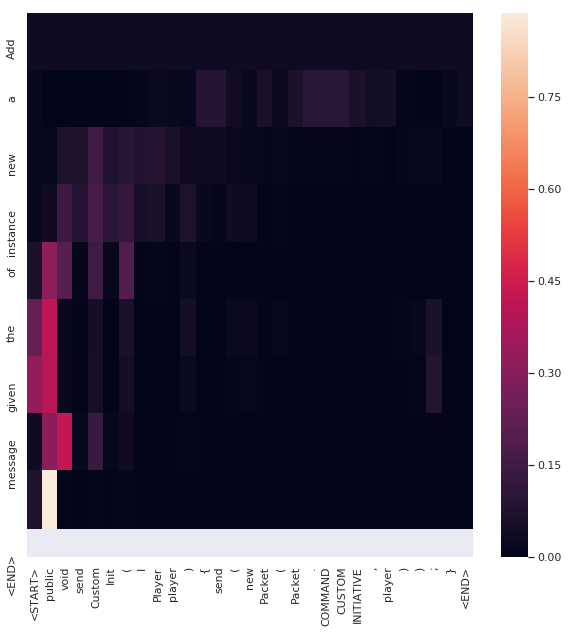

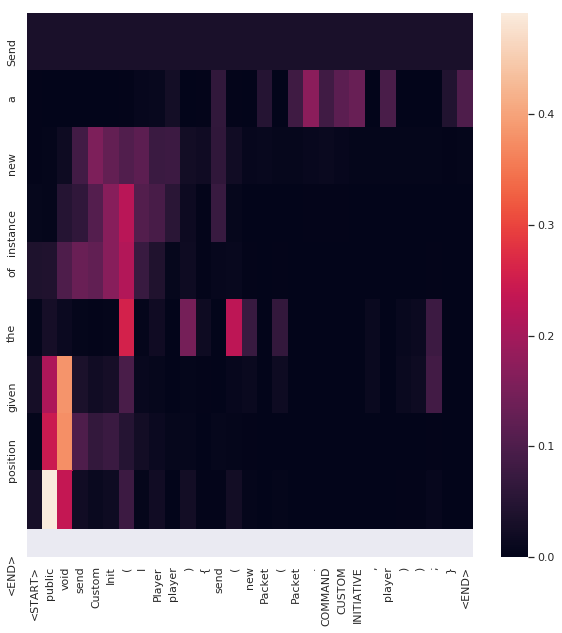

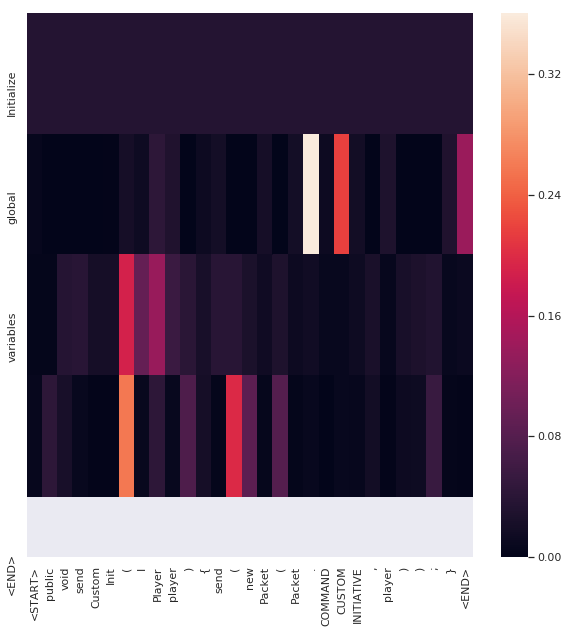

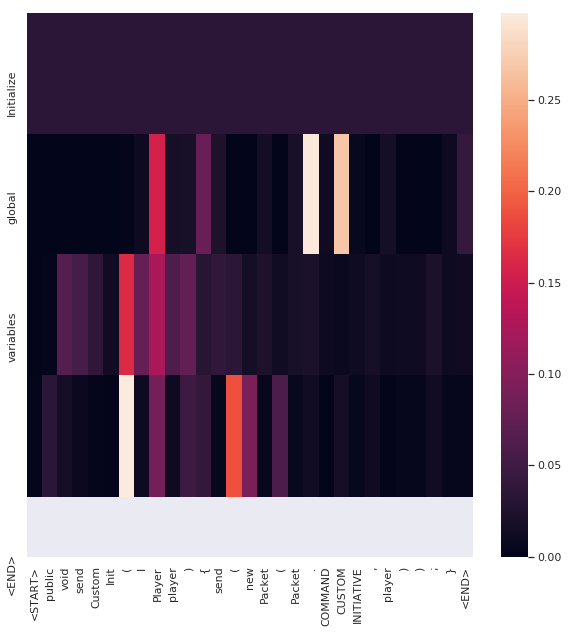

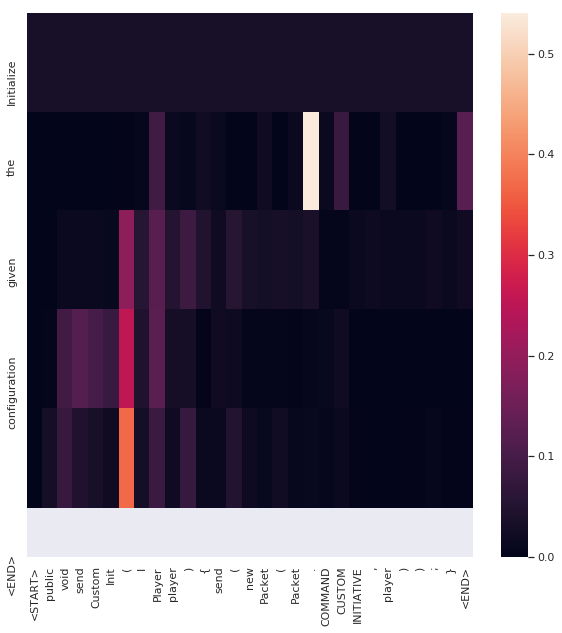

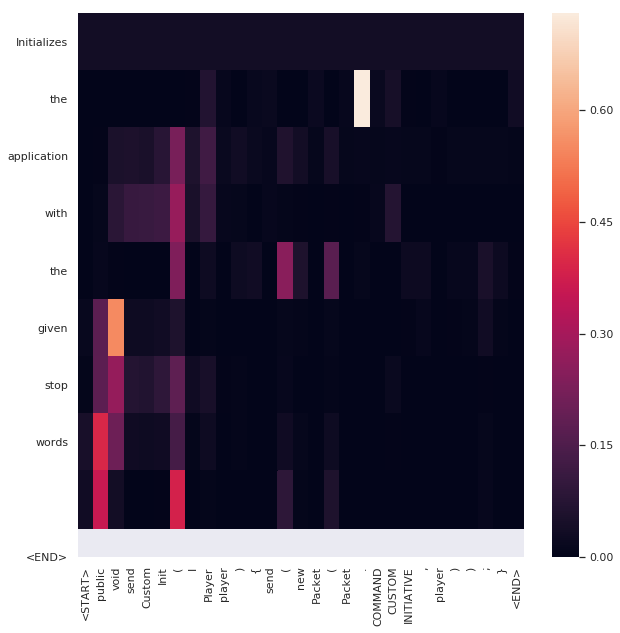

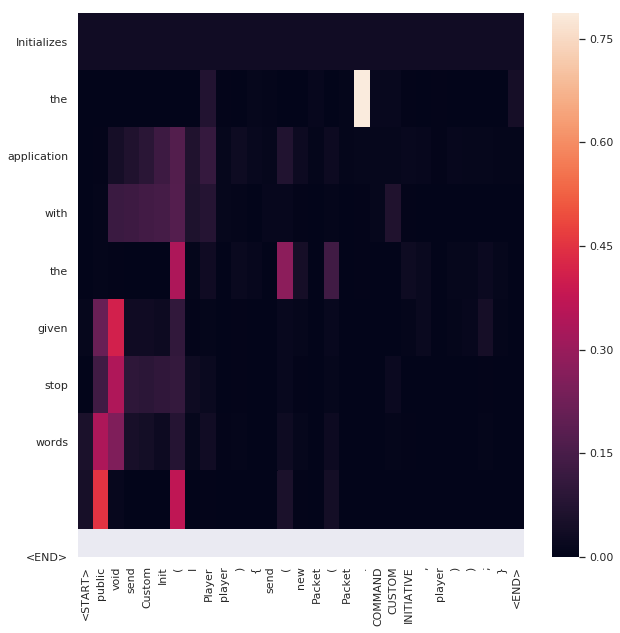

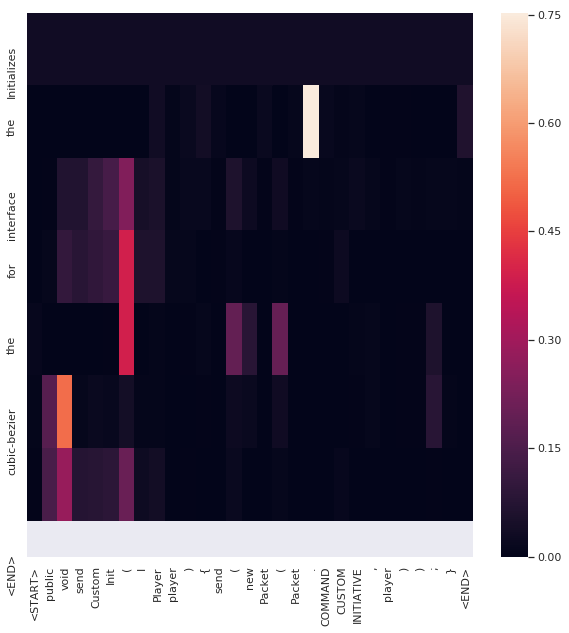

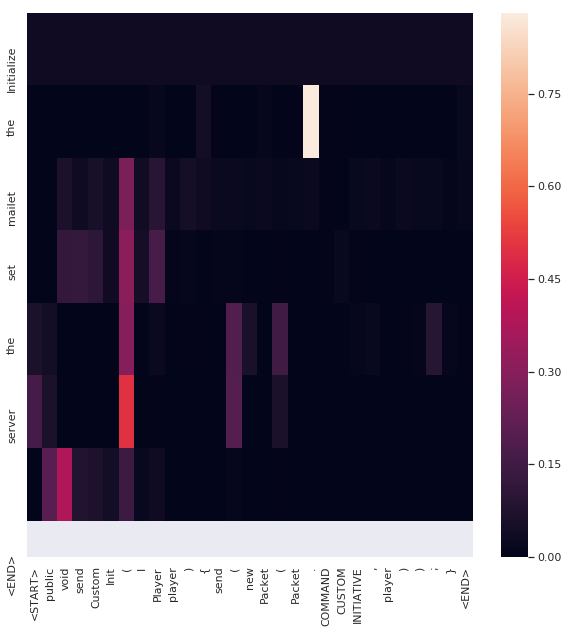

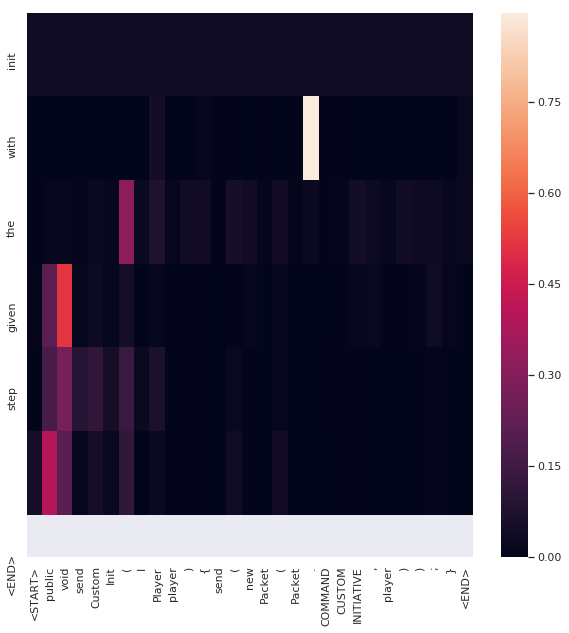

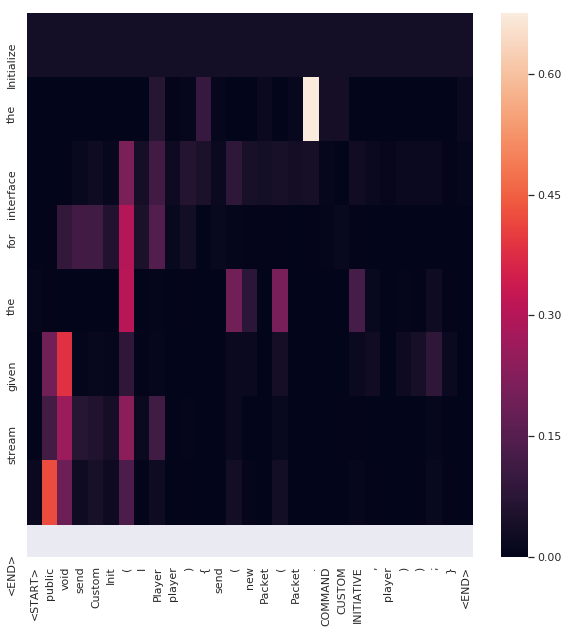

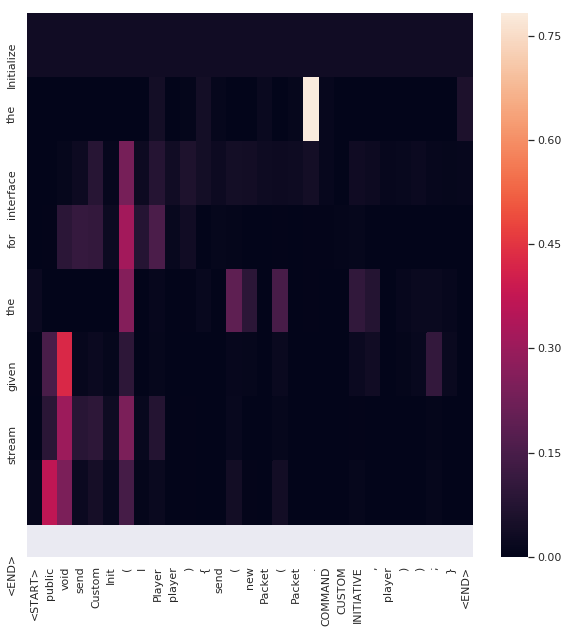

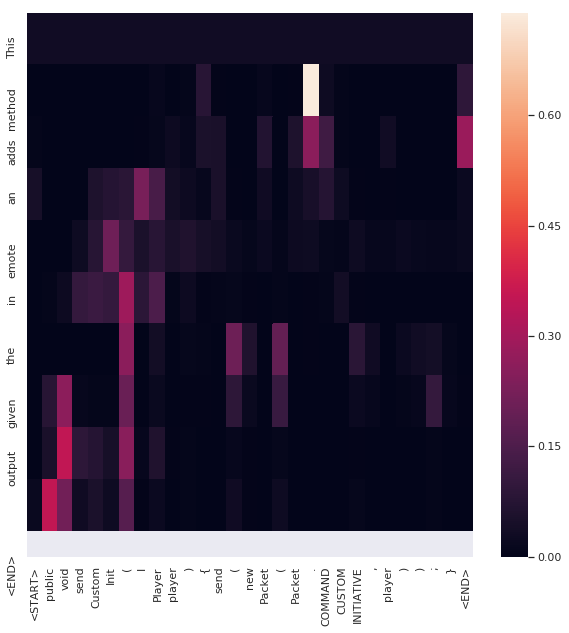

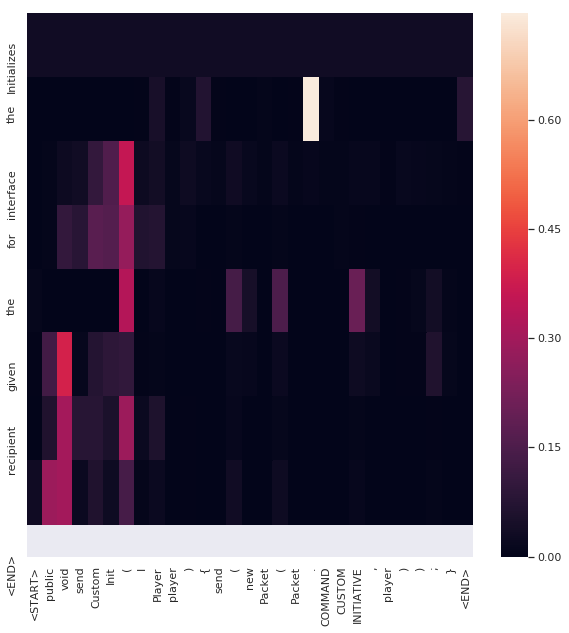

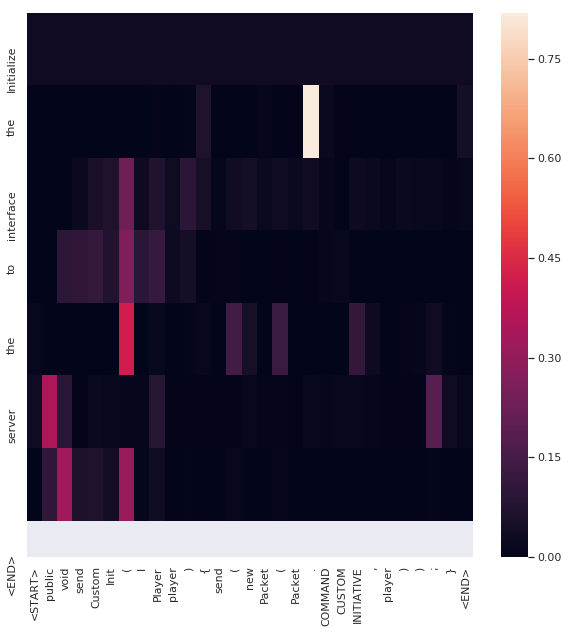

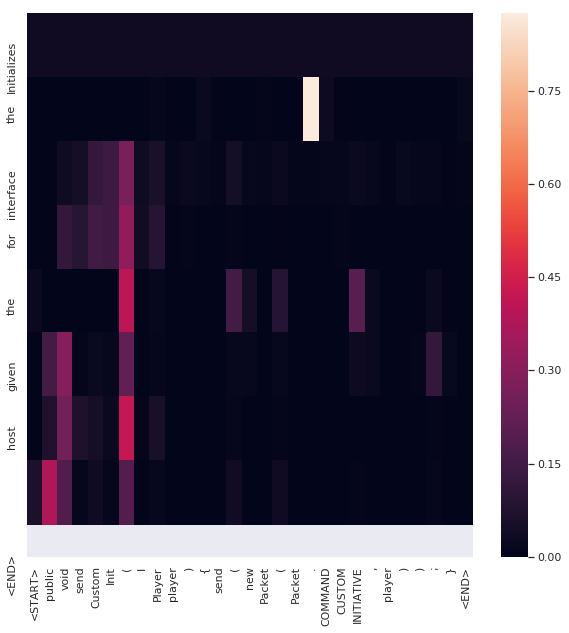

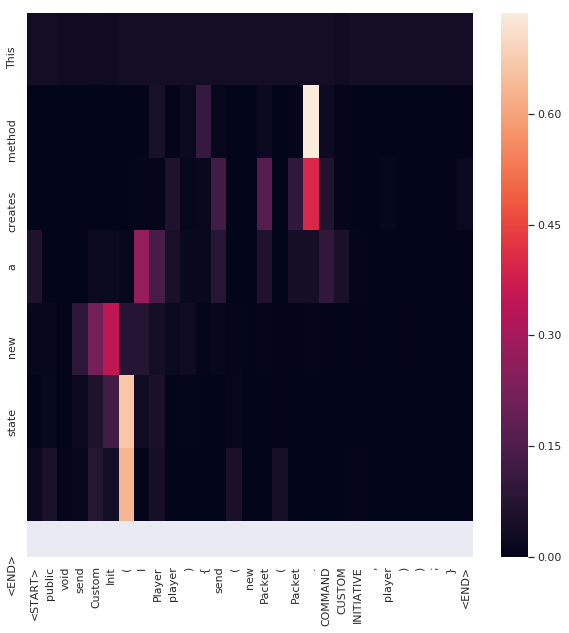

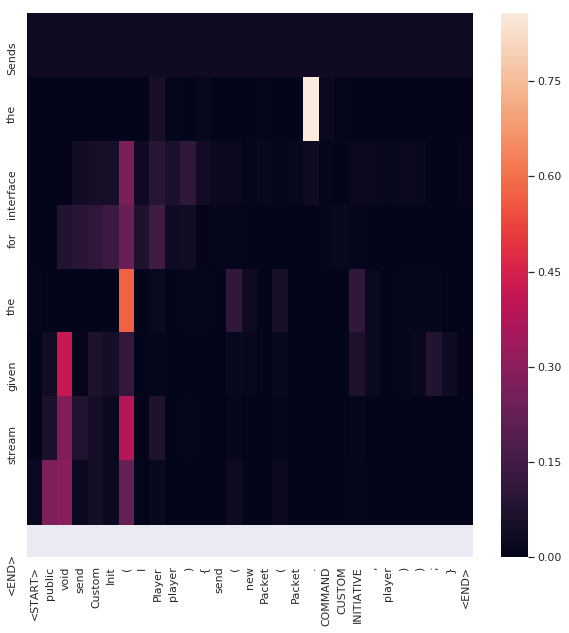

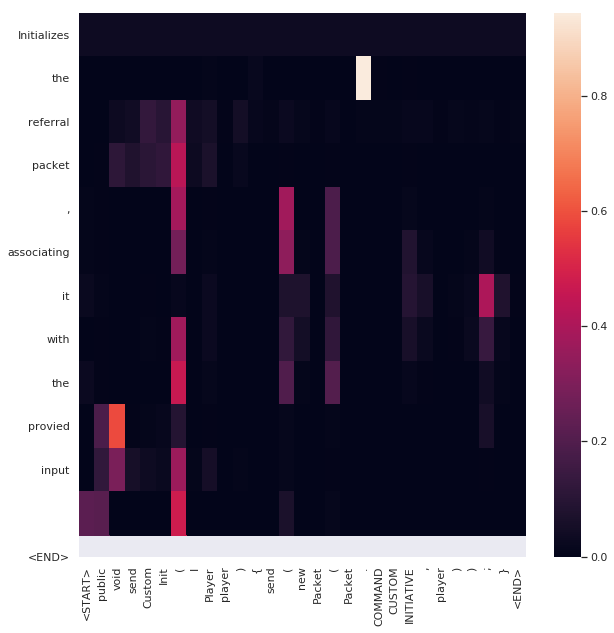

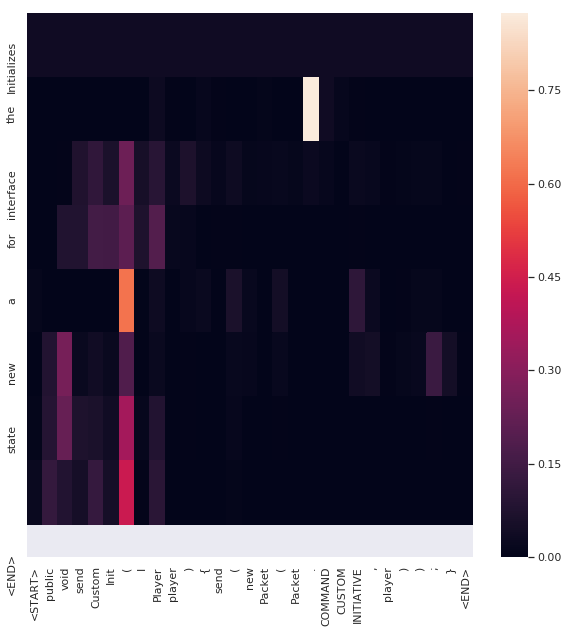

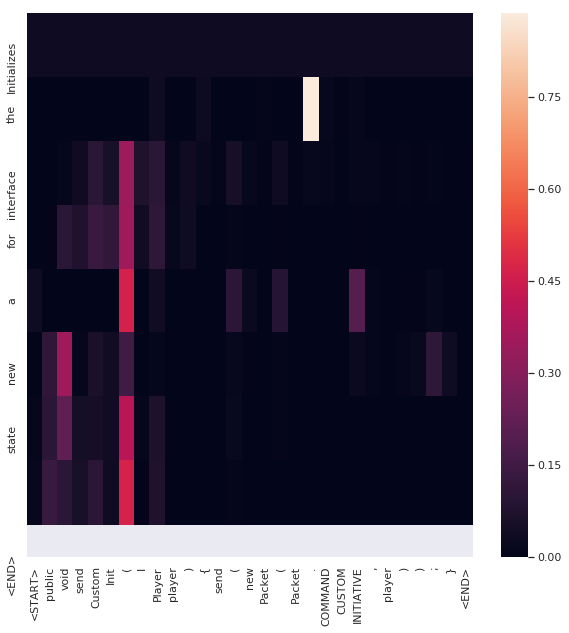

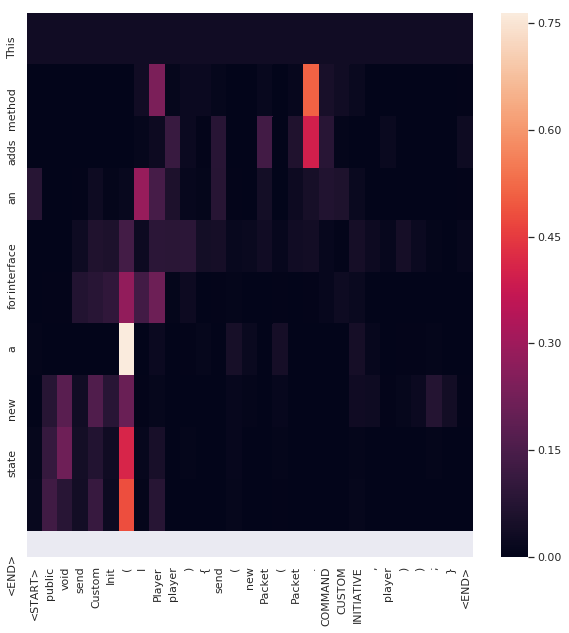

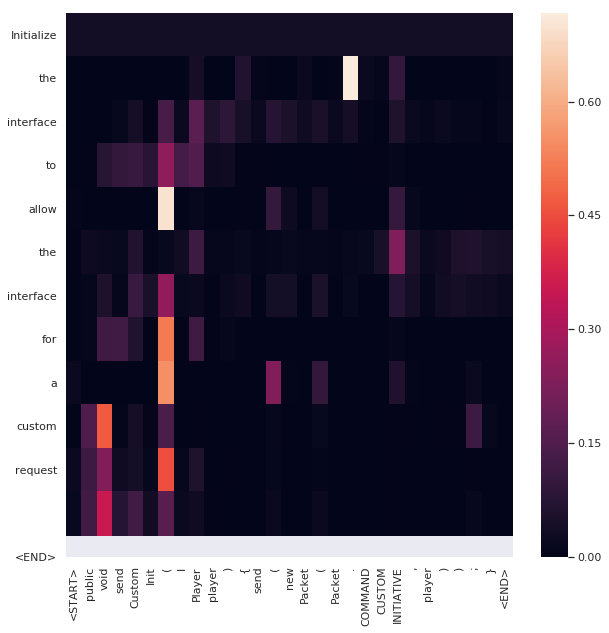

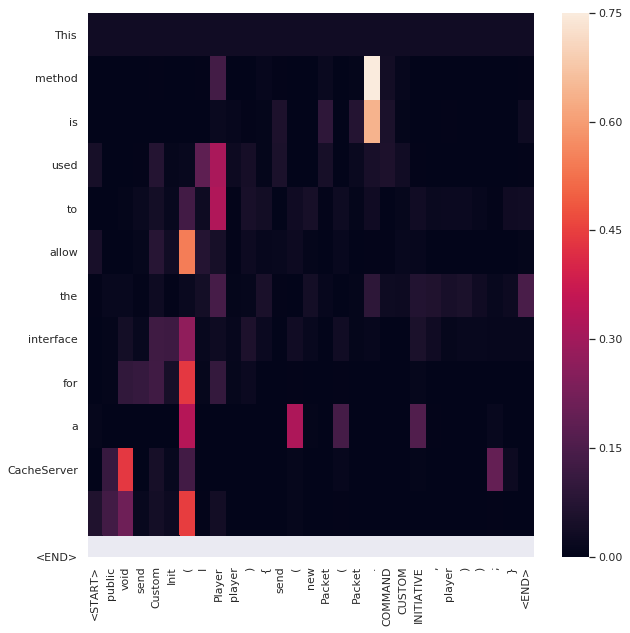

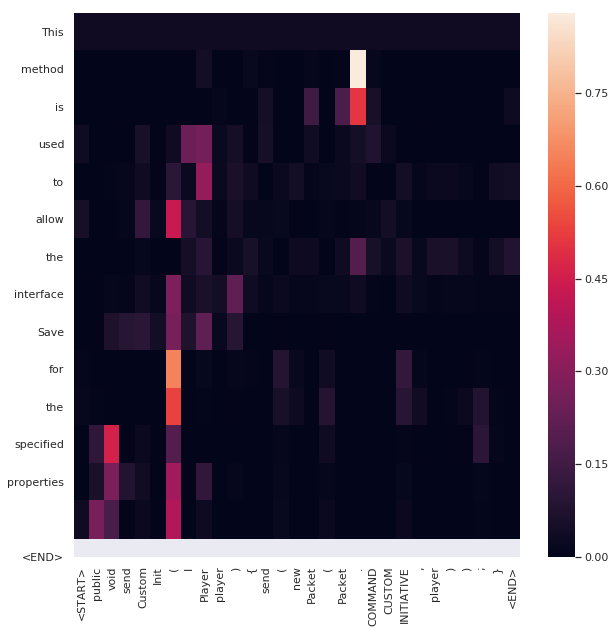

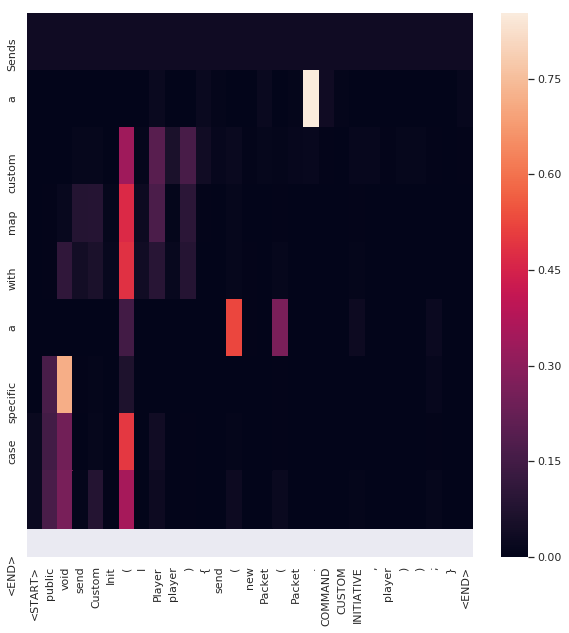

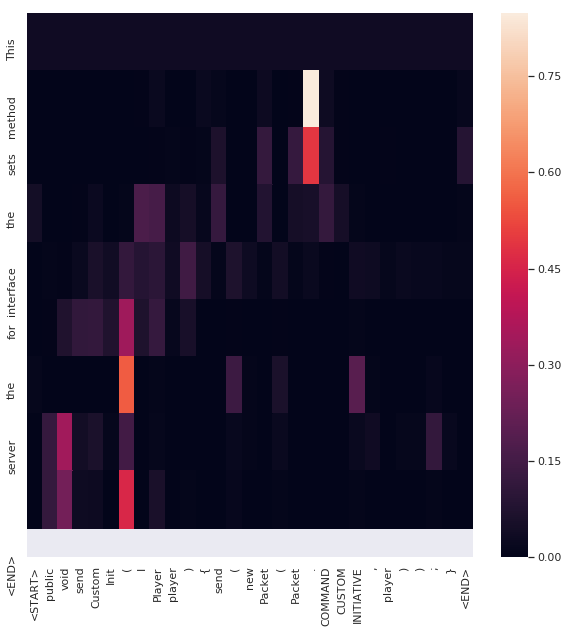

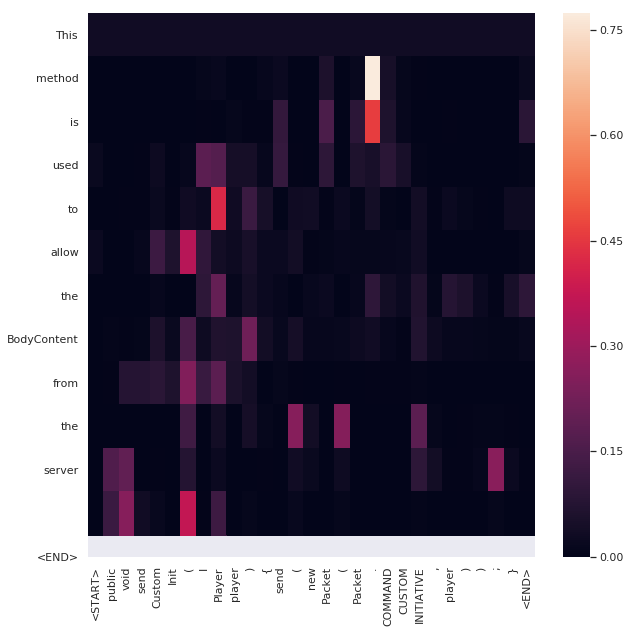

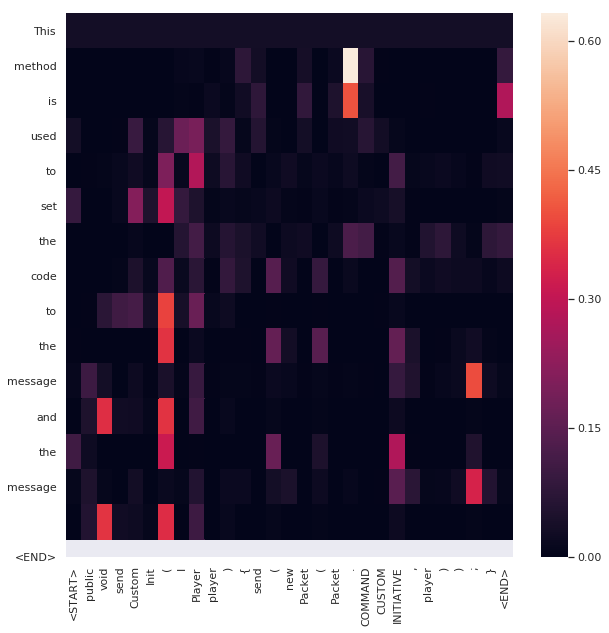

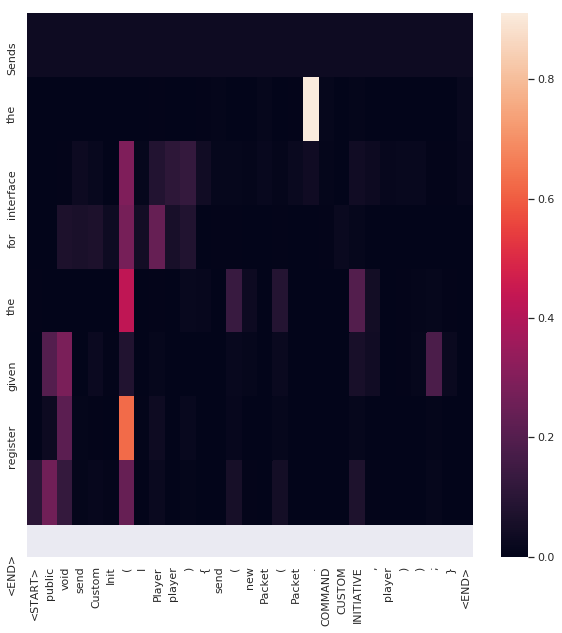

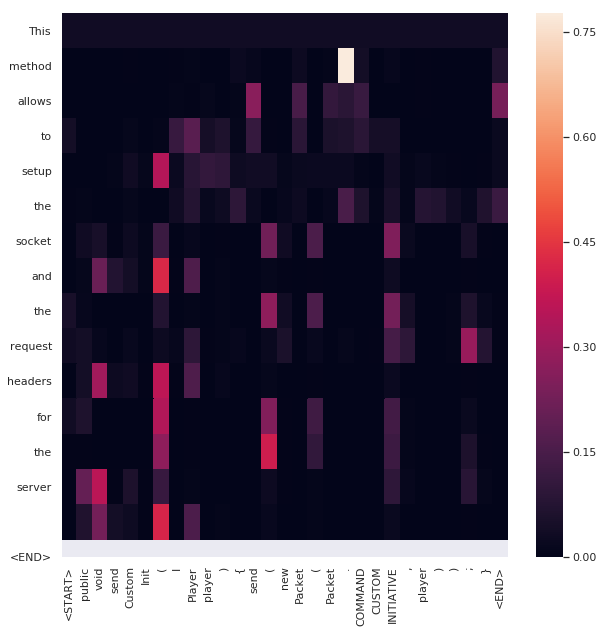

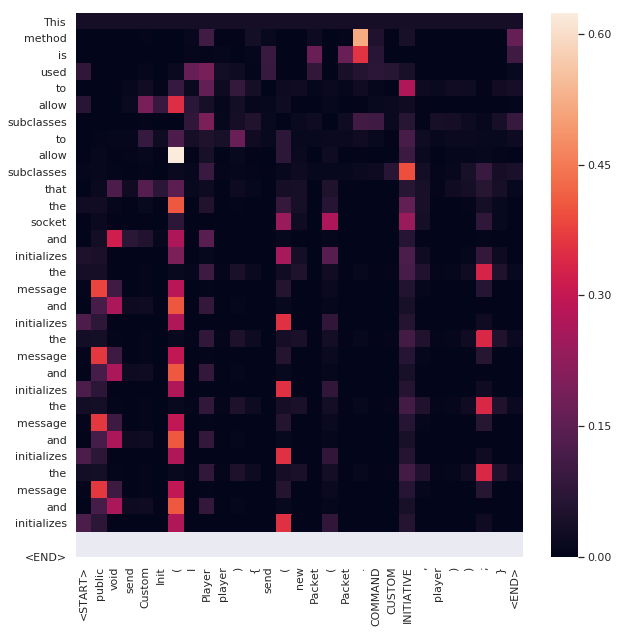

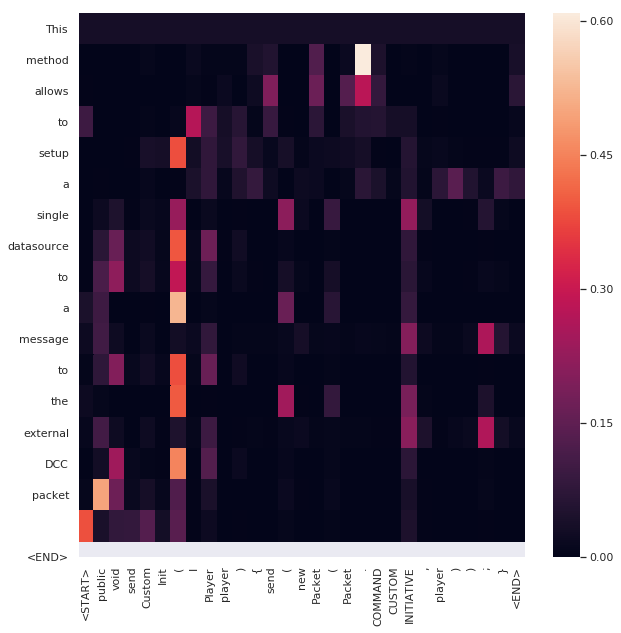

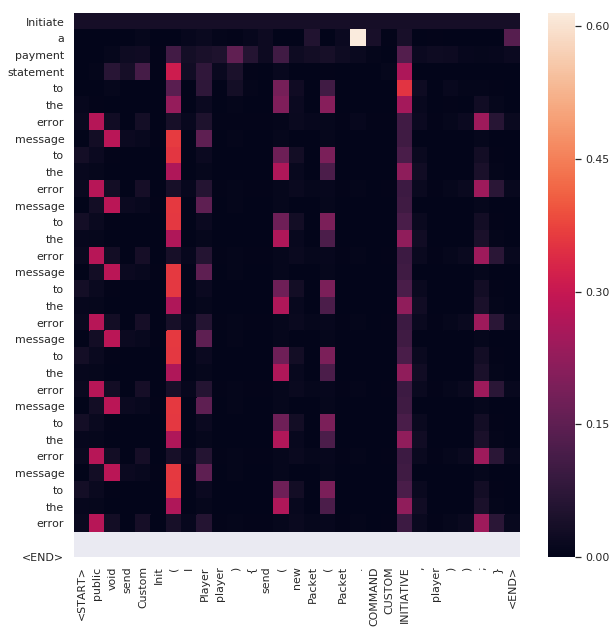

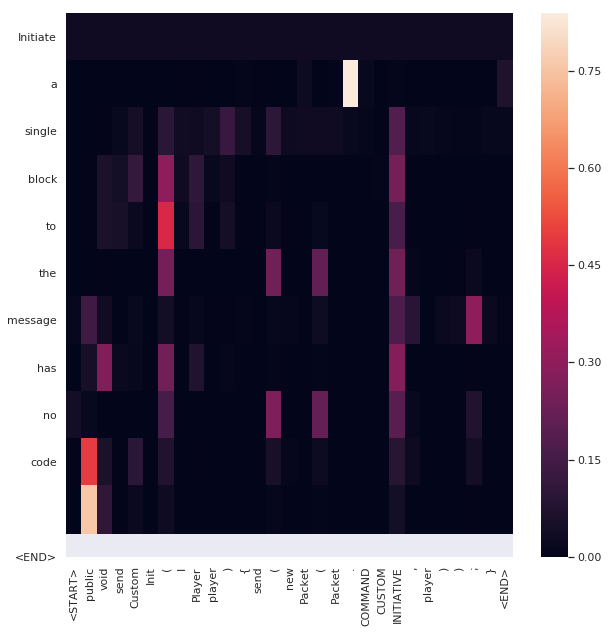

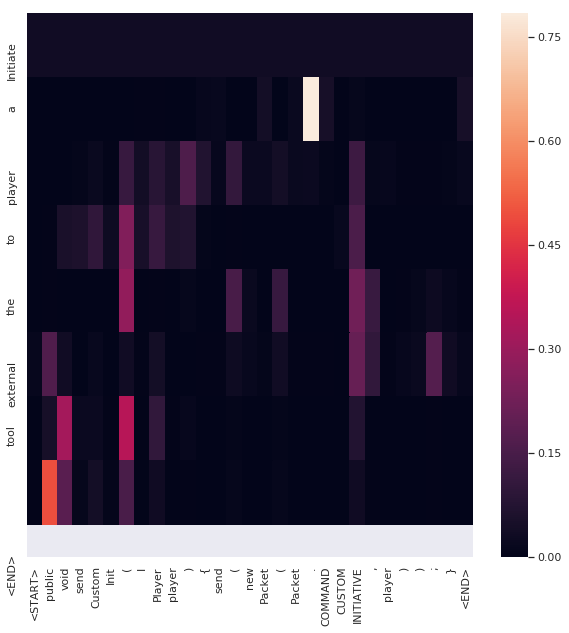

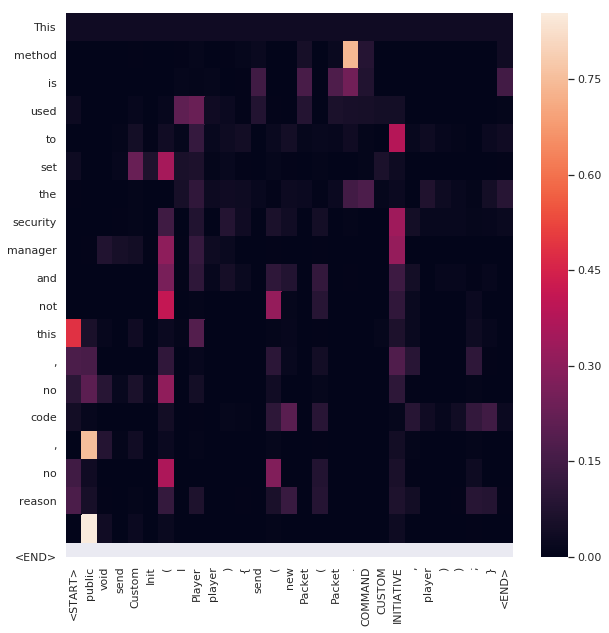

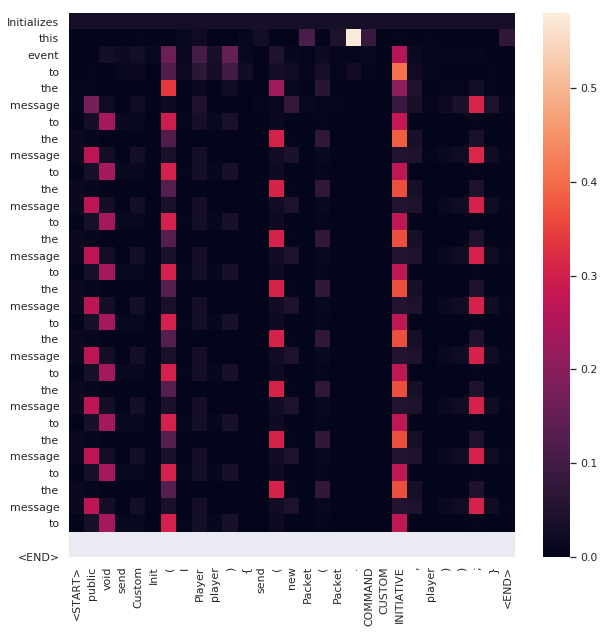

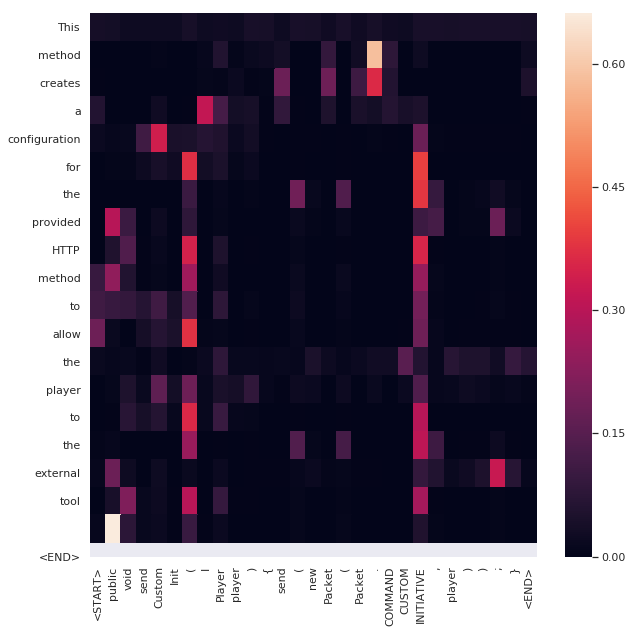

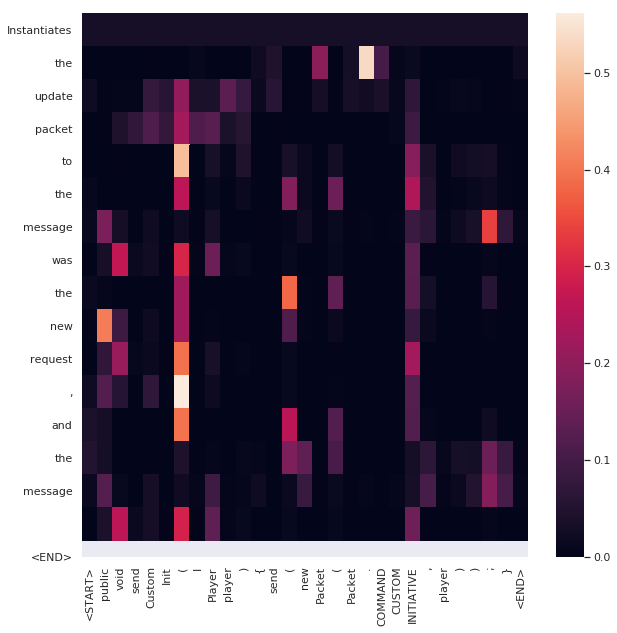

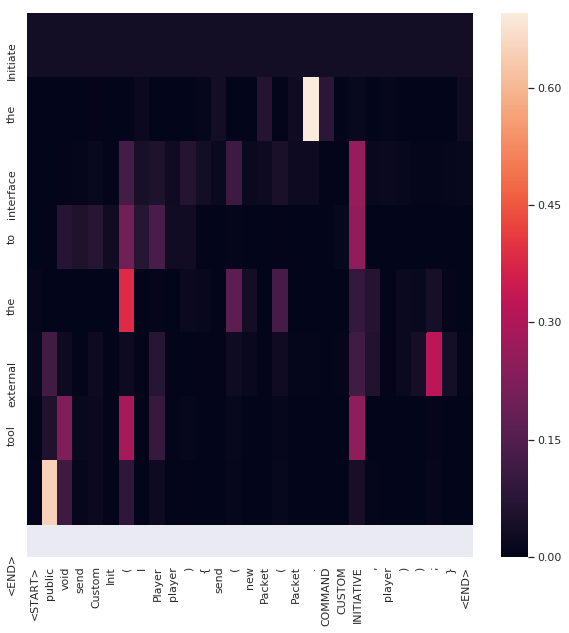

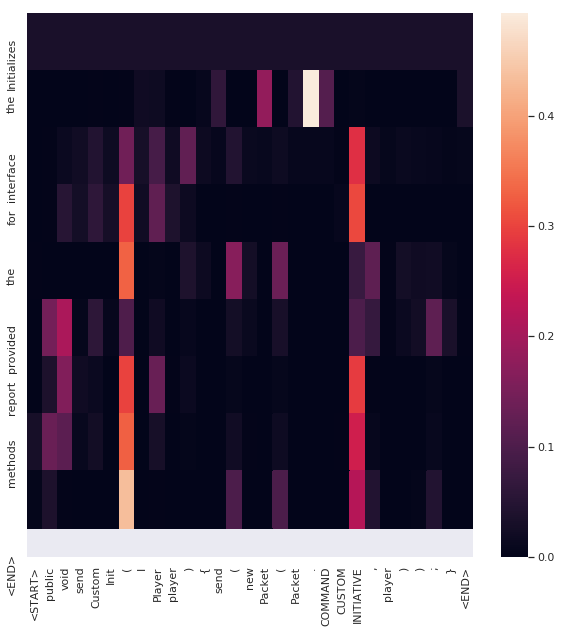

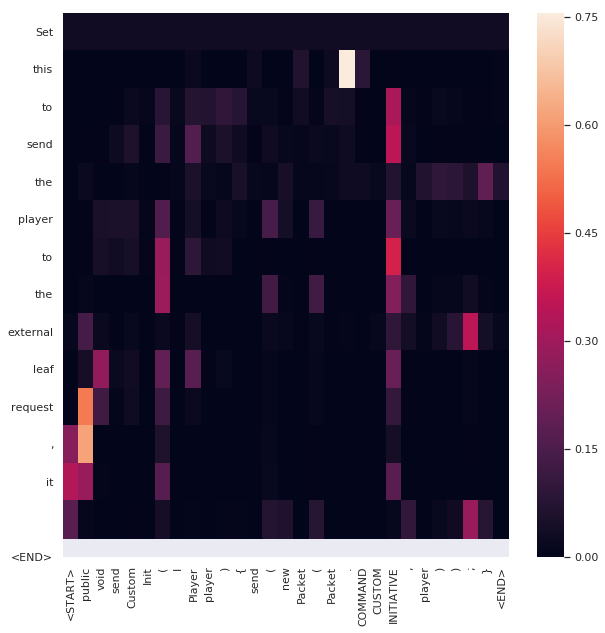

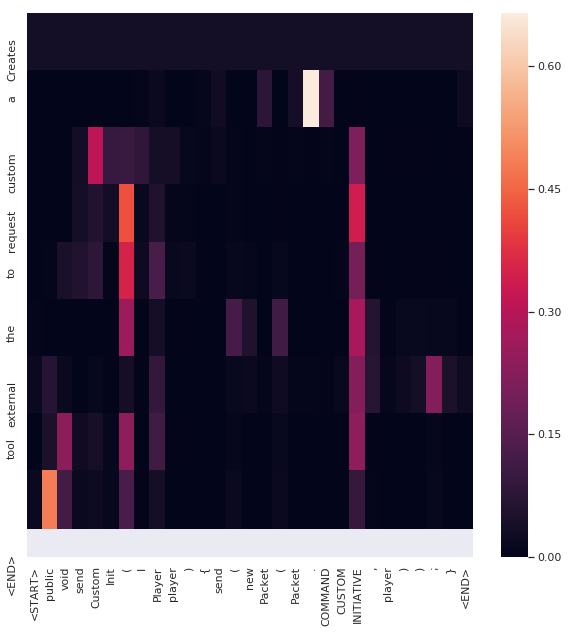

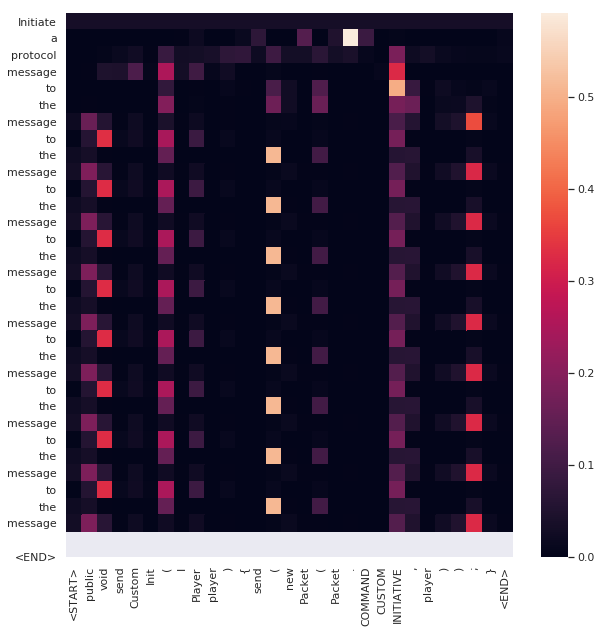

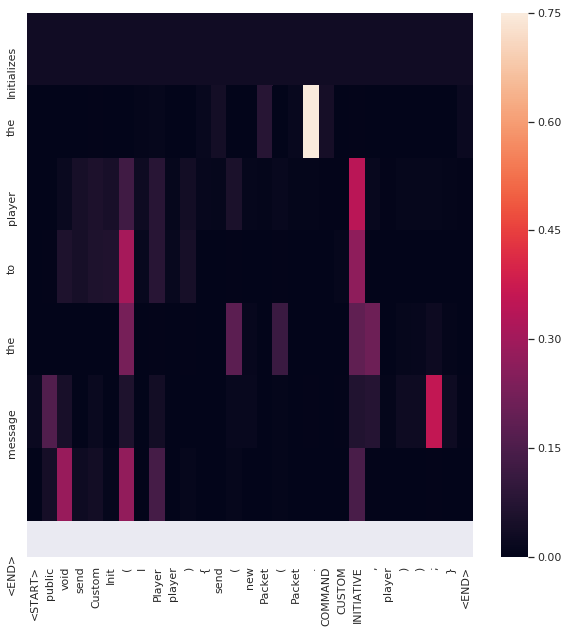

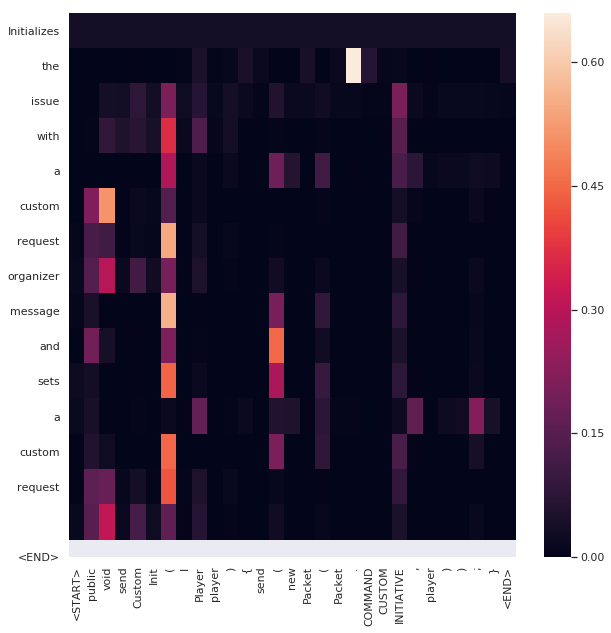

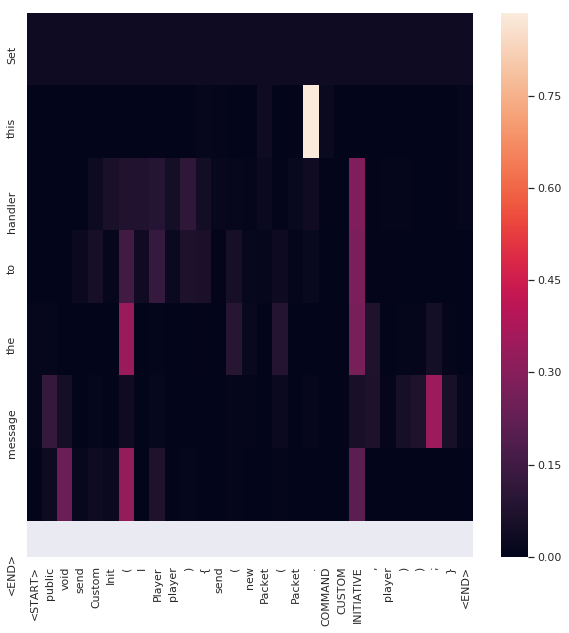

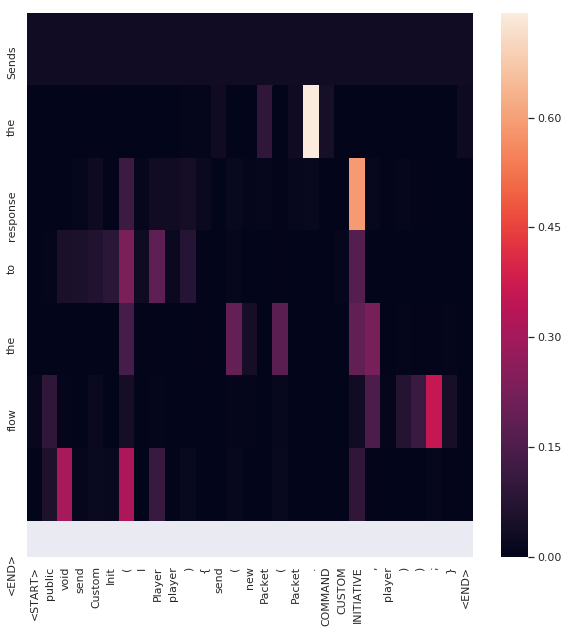

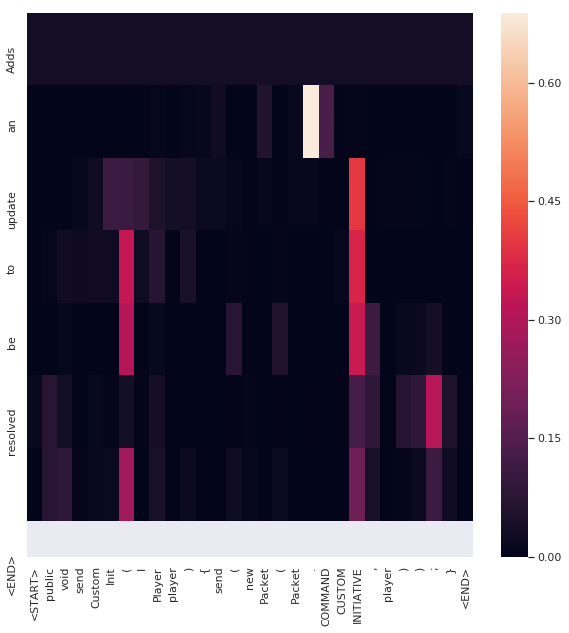

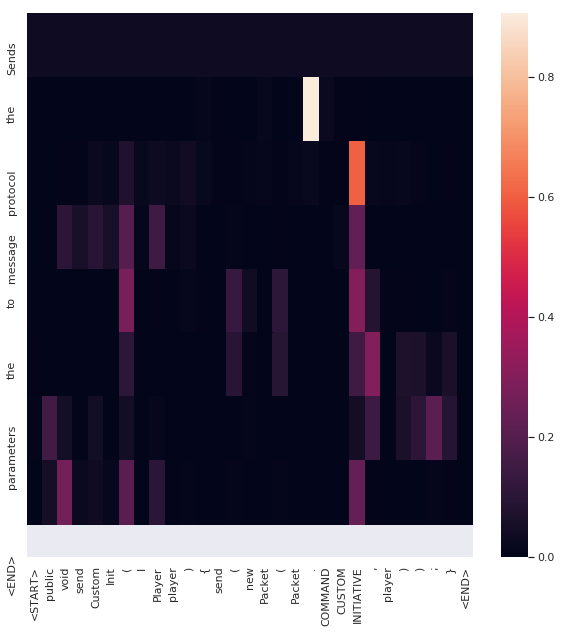

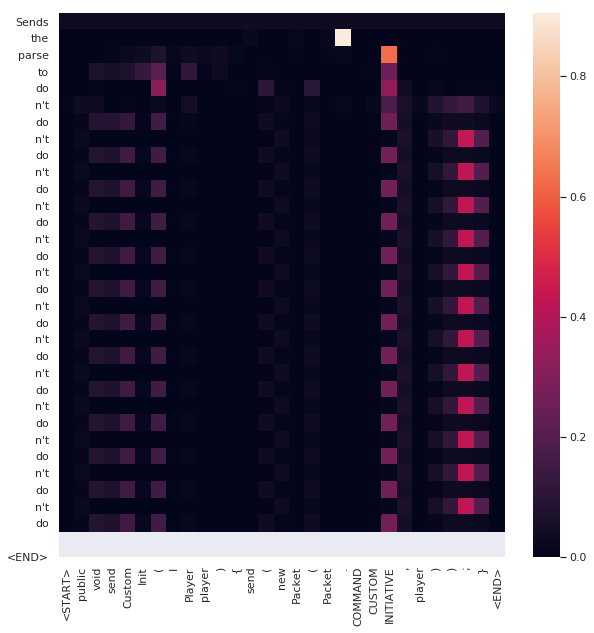

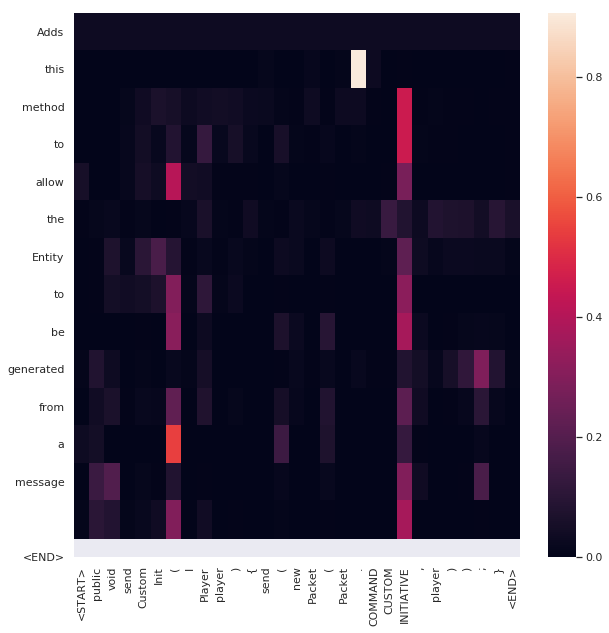

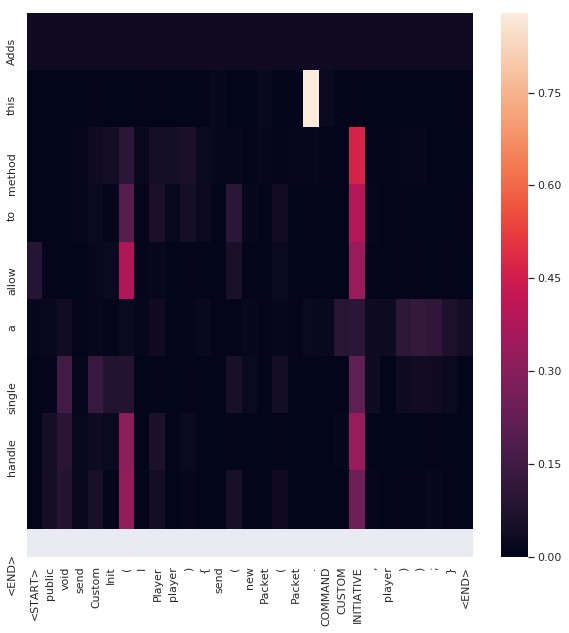

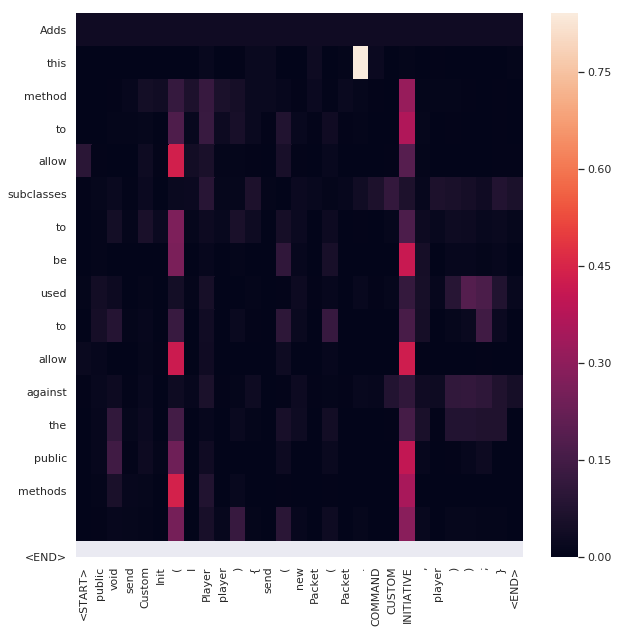

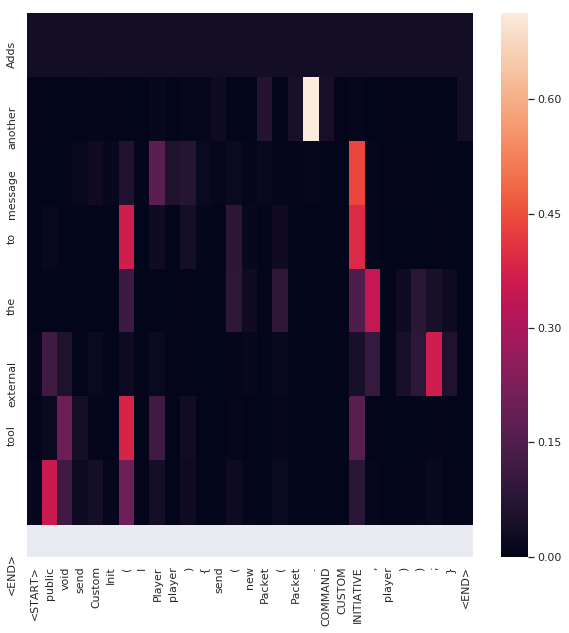

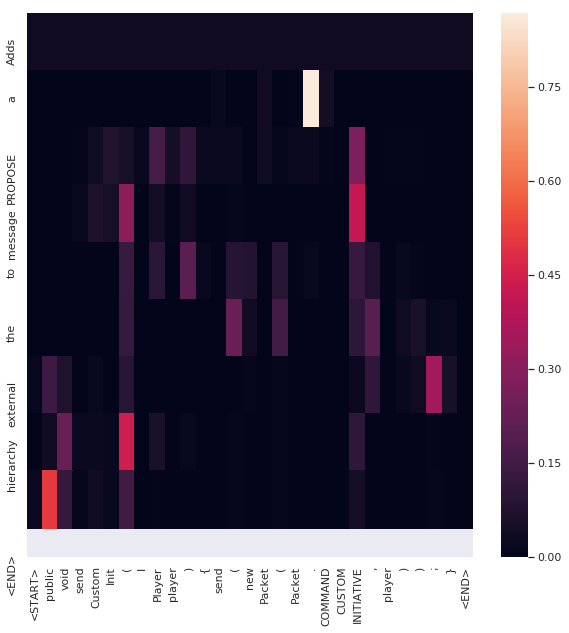

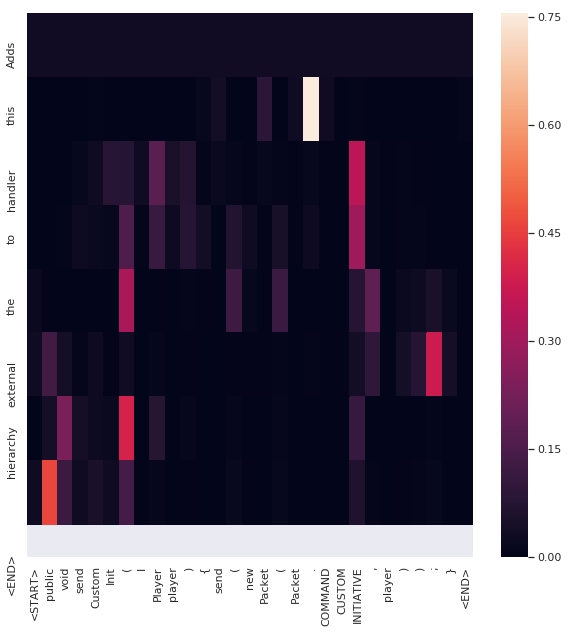

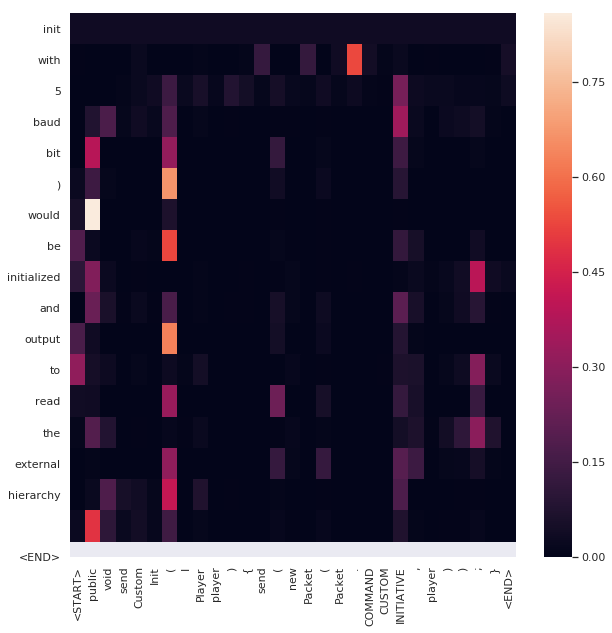

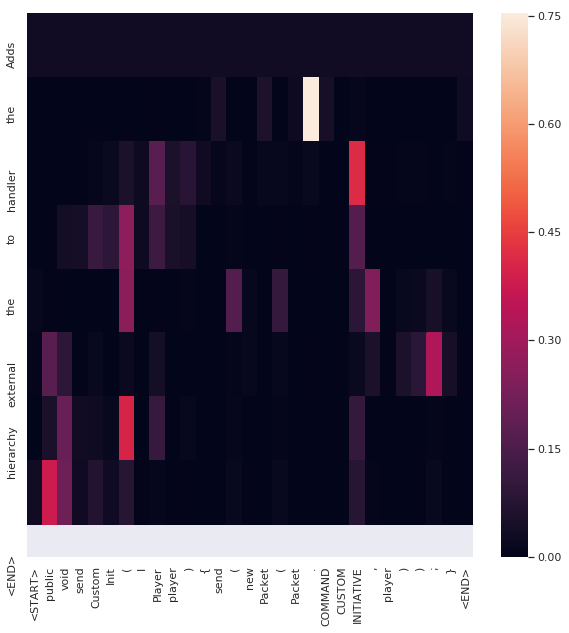

In [11]:
EPOCHS = 60

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden_h, hidden_c = encoder.initialize_hidden_state()
    
    hidden = [hidden_h, hidden_c]
    
    total_loss = 0 

    code_train_batch = getBatch(code_train, BATCH_SIZE)
    
    comment_train_batch = getBatch(comment_train, BATCH_SIZE)
    
    dataset = [(code_train_batch[i], comment_train_batch[i]) for i in range(0, len(code_train_batch))]
    
    np.random.shuffle(dataset)

    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden_h, enc_hidden_c = encoder(inp, hidden)
            
            dec_hidden = [enc_hidden_h, enc_hidden_c]
            
            dec_input = tf.expand_dims([comment_voc.index('<START>')] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(0, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden_h, dec_hidden_c, _ = decoder(dec_input, dec_hidden, enc_output)
                
                dec_hidden = [dec_hidden_h, dec_hidden_c]
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    lossArray = np.append(lossArray, (total_loss / N_BATCH) )
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    
# ======= recording the hyper-parameters of the models ===========
f_parameter = open(checkpoint_dir+"/parameters", "a")
f_parameter.write("EPOCHS="+str(EPOCHS)+"\n")
f_parameter.write("BATCH_SIZE="+str(BATCH_SIZE)+"\n")
f_parameter.write("DATA="+MODE+"\n")
f_parameter.write("OPTIMIZER="+"ADAM"+"\n")
f_parameter.write("EMBEDDING="+str(EMBEDDING_DIM)+"\n")
f_parameter.write("UNITS="+str(UNITS)+"\n")
f_parameter.write("LOSS="+str(list(lossArray))+"\n")
f_parameter.close()

## Plot the learning curve of the training process

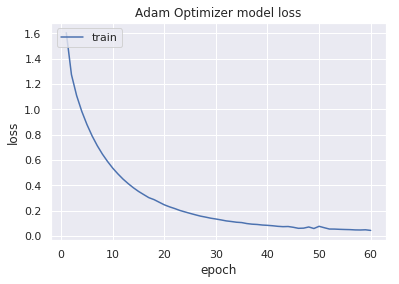

In [12]:
plt.plot(range(1, EPOCHS+1), lossArray, "b", label="train")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Adam Optimizer model loss")
plt.legend(loc = 2)
plt.show()

## Restore the pre-trained model

In [7]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = './training_checkpoints/adam-normal-256-60epochs'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Open the testing set to evaluate the model

In [8]:
f = open('./filter_dataset/filter_test.json')
inputs = f.readlines()
f.close()
test_inputs = []
test_outputs = []
for pair in inputs:
    pair = json.loads(pair)
    test_inputs.append(pair['code'])
    test_outputs.append(pair['nl'])

## Evaluate the model via BLEU4

In [19]:
total_bleu = 0
for index, test in enumerate(test_inputs):
    predict = translate(test_inputs[index], encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ, MODE)
    bleu4_score = bleu4(test_outputs[index], predict)
    total_bleu += bleu4_score
    if (index%1000) == 0:
        print(index)
        
total_bleu = total_bleu / len(test_inputs)
print("bleu4:",total_bleu)

f_parameter = open(checkpoint_dir+"/parameters", "a")
f_parameter.write("BLEU4="+str(total_bleu)+"\n")
f_parameter.close()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
bleu4: 0.3836042053122056


## Generate the comment of one snippet

In [12]:
index = 6
print(test_inputs[index], end="\n")
print("Original comment: ",test_outputs[index], end="\n")
predict = translate(test_inputs[index], encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ, MODE)
print("Predictedd translation: ", predict, end="\n")
bleu4_score = bleu(test_outputs[index], predict, 4)
print("bleu4: {:.4f}".format(bleu4_score), end="\n")

public CataclysmicDemographicModel(Parameter N0Parameter,Parameter N1Parameter,Parameter growthRateParameter,Parameter timeParameter,Type units,boolean useSpike){
  this(CataclysmicDemographicModelParser.CATACLYSM_MODEL,N0Parameter,N1Parameter,growthRateParameter,timeParameter,units,useSpike);
}

Original comment:  Construct demographic model with default settings
Predictedd translation:  Construct demographic model with default 's default 's default 's default 's default 's default 's default 's default 's default 's default 's default 's default 's default 's default 
bleu4: 0.1547


In [64]:
tf.test.is_gpu_available()

True